# Data Analysis Notebook
This notebook allows you to analyse functional Breast DCE-MRI datasets, starting from the raw DICOM files up to displaying time course signal intensity curves showing tumour uptake of contrast agent.

Note that in order to display time course signal intensity curves, there must be valid ROIs for the corresponding dataset. Currently, they have to be drawn in ImageJ, following a name convention. <!-- (TODO: Add name convention) -->

Although most of the folder structure and data processing is done automatically, there are some manual interactions that still need to happen. They are indicated in the corresponding sections of this notebook.

This notebook replicates the one available for Google Colab, but using local resources, so it may work faster, but need to install a development environment locally.

# Setting up the running environment
These set of cells will prepare the environment to run the registration workflow

## Loading Modules
Work in the environment ISANDEX:
```workon isandex```

In [1]:
import os
import cv2 
import itk
import sys
import math
import time
import ants
import json
import glob
import shutil
import roifile  # Opening the ImageJ-created ROIs (https://pypi.org/project/roifile/)
import itertools
import numpy as np
import pandas as pd
import dicom2nifti
import pydicom as pyd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
from directory_tree import display_tree  # Nice tool to display directory trees (https://pypi.org/project/directory-tree/)

print('All external modules loaded. Please check above for any error message!')
%matplotlib inline


All external modules loaded. Please check above for any error message!


## Auxiliar Functions

In [2]:
def list_folder_content(path, show_hidden=False, sort=True):
    if show_hidden:
        ddfldrlst = os.listdir(path)
    else:
        ddfldrlst = list(filter(lambda item: not item.startswith('.'),os.listdir(path)))
    if sort:
        return sorted(ddfldrlst)
    else:
        return ddfldrlst

def display_folder_list(file_list):
    print('\n'.join(f'[{idx}] - {file_idx}' for idx, file_idx in enumerate(file_list)))

def get_path_to_process(full_path):
    print('Folder content:')
    print(display_tree(full_path, header=True, string_rep=True, show_hidden=False, max_depth=2))
    folder_content = list_folder_content(full_path)
    # Ideally we'll have only one sub-folder inside the PreTreatment folder. If more than one, then we have to choose, but by default, we'll select the first one.
    idx_reg = 0
    if len(folder_content) > 1:
        display_folder_list(folder_content)
        idx_sel = input(f'Select the folder with the dataset_to_process to process (0-{len(folder_content)-1} or just press Enter to proceed with sub-folder {folder_content[idx_reg]}):')
        if idx_sel:
            idx_reg = int(idx_sel)
    path2data = os.path.join(full_path, folder_content[idx_reg])
    print(f'Will process {folder_content[idx_reg]}')
    return path2data

def check_time_points(path_to_check, nmax = 6, verbose=False):
    if path_to_check is not None:
        nr_of_folders = list_folder_content(path_to_check)
        print(f'Folder {path_to_check} seems Ok' if len(nr_of_folders)== nmax else f'Error! Check path {path_to_check} is the correct one')
        if verbose:
            print('Listing folder content:')
            display_tree(path_to_check, max_depth=1)
        return nr_of_folders if len(nr_of_folders) == nmax else None
    else:
        return None

def add_prefix_to_filename(full_path, prefix=None):
    # Assume the last part of the path is the filename (with extension)
    file_path, file_name_ext = os.path.split(full_path)
    if prefix:
        updated_filename = '_'.join([prefix, file_name_ext])
        return os.path.join(file_path, updated_filename)
    else:
        return prefix

def itk2ants(itkInput):
    antsOutput = ants.from_numpy(itk.GetArrayFromImage(itkInput).T,
                                 origin=tuple(itkInput.GetOrigin()),
                                 spacing=tuple(itkInput.GetSpacing()),
                                 direction=np.array(itkInput.GetDirection()))

    return antsOutput

def ants2itk(antsInput):
    itkOutput = itk.GetImageFromArray(antsInput.numpy().T)
    itkOutput.SetOrigin(antsInput.origin)
    itkOutput.SetSpacing(antsInput.spacing)
    itkOutput.SetDirection(antsInput.direction)

    return itkOutput

def getenv(colab=False):
    """
    Requires sys and os modules:
    import sys
    import os
    See https://docs.python.org/3/library/sys.html & https://stackoverflow.com/questions/446209/possible-values-from-sys-platform
    for possible values for sys.platform
    Update 03/04/2024: Added support when running inside Google Colab Environment, via the optional flag "colab"
    """
    if colab:
      # Requires mounting the Google Drive before
      HOMEPATH = '/content/drive/MyDrive'
    else:
      if sys.platform == 'win32':
          env_home = 'HOMEPATH'
      elif (sys.platform == 'darwin') | (sys.platform == 'linux'):
          env_home = 'HOME'
      HOMEPATH = os.getenv(env_home)

    return HOMEPATH

def check_path_exist(path, file=False):
    """
    Flag FILE indicates the path contains a file name (FLAG=TRUE) or the path only points to a folder (FLAG=FALSE (Default))
    """
    if file:
        is_path = os.path.isfile(path)
    else:
        is_path = os.path.isdir(path)

    print(f'{"OK:" if is_path else "ERROR:"} Path to {"file" if file else "folder"} {path} does{"" if is_path else " NOT"} exist')

    return is_path

def create_folder_structure(root_path, sub_dirs, create=True):
  """
  Create subdirectories insode HOMEPATH (using makedirs to avoid altering existing folders)
  ROOT_PATH must exist, otherwise it issues an error
  SUB_DIRS is a dictionary with the subfolder required inside HOMEPATH

  """
  subdirpaths = {}
  for folder_name, sub_dir in sub_dirs.items():
    path_to_subdir = os.path.join(root_path, sub_dir)
    if create:
        os.makedirs(path_to_subdir, exist_ok=True)
        subdirpaths[folder_name] = path_to_subdir


  return subdirpaths
print('All auxiliar functions defined. Ready to proceed')


All auxiliar functions defined. Ready to proceed


## Path to Data

In [49]:
# Create the Folder Structure (slightly different to the one created for testing registration methods, but still follows the same criteria)
HOMEPATH = getenv()
# JU 19/04/2024: Added variable STUDYNAME to allow processing other datasets, such as from I-SPY2 trial
# STUDYNAME = 'ISPY2'
STUDYNAME = 'fMRIBreastData'
# STUDYNAME = 'RICE001'

ROOTPATH = os.path.join(HOMEPATH, 'Data', STUDYNAME)

SUBDIRFLDRS = {'STUDYFLDR':   'StudyData',
               'NIFTIFLDR':   'NiftiData',
               'ROIFLDR':     'ROIData',
               'SRCDCMFLDR':  'rawS3',
               'REGOUTFLDR':  'RegOutput',
               'CFGFLDR':     'configFiles',
               'OUTPUTFLDR':  'output',
               'LOGFLDR':     'logs'
              }
subdir_paths = create_folder_structure(ROOTPATH, SUBDIRFLDRS)

# DICOM Sources:
srcpath = subdir_paths['SRCDCMFLDR']
dstpath = subdir_paths['STUDYFLDR']
fext = 'dcm'


## Download configuration files and previously defined ROIs

In [50]:
aws_path = 'https://fbdcemri-config-files.s3.amazonaws.com'
config_pars = ['Par0032_bsplines.txt','Par0032_rigid.txt', 'ROI_Dictionary.json']
for config_par in config_pars:
  config_local_path = os.path.join(subdir_paths['CFGFLDR'], config_par)
  if os.path.isfile(config_local_path):
    print(f'File {config_par} already exist, nothing done')
  else:
    path_to_cfgfile = '/'.join([aws_path, config_par])
    if sys.platform == 'darwin':
      !curl {path_to_cfgfile} -o {os.path.join(subdir_paths['CFGFLDR'],config_par)}
    else:
      !wget {path_to_cfgfile} -P {subdir_paths['CFGFLDR']}
    print(f"File {config_par} saved at {subdir_paths['CFGFLDR']}")

# ROI set:
ROIsetName = f'{STUDYNAME}_datasets.zip'
roi_set_zip_path = '/'.join([aws_path, ROIsetName])
roi_local_path = os.path.join(subdir_paths['ROIFLDR'], ROIsetName)
if os.path.isfile(roi_local_path):
  print(f'ROI set already exists, nothing downloaded')
else:
  if sys.platform == 'darwin':
    !curl {roi_set_zip_path} -o {os.path.join(subdir_paths['ROIFLDR'], ROIsetName)}
  else:
    !wget {roi_set_zip_path} -P {subdir_paths['ROIFLDR']}

if os.path.isfile(roi_local_path):
  print(f"ROI set file located at {roi_set_zip_path} has been stored at {subdir_paths['ROIFLDR']}")
  # JU 19/04/2024: Added the option '-o' so by default overwrites the ROIs taken the newest available in the S3 bucket
  !unzip -o {roi_local_path} -d {subdir_paths['ROIFLDR']}


File Par0032_bsplines.txt already exist, nothing done
File Par0032_rigid.txt already exist, nothing done
File ROI_Dictionary.json already exist, nothing done
ROI set already exists, nothing downloaded
ROI set file located at https://fbdcemri-config-files.s3.amazonaws.com/fMRIBreastData_datasets.zip has been stored at /Users/joseulloa/Data/fMRIBreastData/ROIData
Archive:  /Users/joseulloa/Data/fMRIBreastData/ROIData/fMRIBreastData_datasets.zip
  inflating: /Users/joseulloa/Data/fMRIBreastData/ROIData/datasets/CR-ANON68760/CR-Post-Treatment-20230120/landmarks/CR-Post-Treatment-20230120-Slices077-115-Frame002.jpg  
  inflating: /Users/joseulloa/Data/fMRIBreastData/ROIData/datasets/CR-ANON68760/CR-Post-Treatment-20230120/landmarks/RoiSet-Frame001-301.zip  
  inflating: /Users/joseulloa/Data/fMRIBreastData/ROIData/datasets/CR-ANON68760/CR-Post-Treatment-20230120/landmarks/RoiSet-Frame002-301.zip  
  inflating: /Users/joseulloa/Data/fMRIBreastData/ROIData/datasets/CR-ANON68760/CR-Pre-Treatme

## Debugging flags

In [55]:
# default settings:
DEBUGMODE = True
BATCHMODE = True # TRUE: it runs the registration for all dataset within STUDYPATH; FALSE (DEFAULT): allows to pick a specific dataset to register
# Additional Flags to control execution of subsequent cells:
RUNREG = False # TRUE: it runs the registration cell; FALSE (DEFAULT): skips the registration to save time when just exploring the results
# For the conversion, we need to consider a wider set of options:
COMPRESSION = True # Controls the extension file output by dicom2nifit: If TRUE ==> .nii.gz Else FALSE ==> .nii
REORIENT = False # Controls the vertical flip of the Nifti output: If TRUE (Default) ==> output follow LAS orientation (visualisation requires to flip vertically the images) Else FALSE ==> Output appears with the same orientation than the DICOM

# Flags used during data conversion:
# TODO: Ensure when concat_vol=True it works correctly for other datasets (e.g. I-SPY2)
OVER_WRITE_NIFTI = False # If the file exists, doesn't overwrite (i.e. doesn't convert it again)
# The variable concat_vol should only affect when convertind from DICOM to Nifti, not when registering data.
CONCAT_VOL = False

REMOVE3DVOL = False  # To save disk space we can remove the individual 3D volumes, but that will cause an error in the registration, so have to be kept as FALSE


# PLEASE READ: Input required
Now that the folders have been created, (manually) place the dicom (raw) data into the ```rawS3``` folder (or whatever value is in ```subdir_paths['SRCDCMFLDR']```)

After done that, we'll sort them out automatically in the ```subdir_paths['STUDYFLDR']```

# Files preparation
## Sort out DICOM folders
Sort out dicom files following this order:
* PatientID () --> Not used
* PatientName () --> Use this as it is also used by Radiologists, so to keep consistency
* StudyID () --> Not needed
* StudyDate () --> This defines the pre- and post-treatment (just the earliest is pre- and the latest is post-)
* SeriesNro () --> This is relevant to later eliminate any possible in-scanner post-processed data
* SeriesDescription ()


In [52]:
# Get the list of dicom files in the folder, use the extension defined by FEXT:
dcmlist = glob.glob(os.path.join(srcpath,f'*.{fext}'))
print(f'There are {len(dcmlist)} files to process in {srcpath}. Please wait...')

start_time = time.perf_counter()

nels = len(dcmlist)
nsteps = 10**math.floor(math.log10(0.01*nels)+1)

print(''.join(['*']*100))
for nimg, dcm in enumerate(dcmlist):
    if (nimg % nsteps)==0:
        print(f'\t{nels-nimg} files to process...')

    ds = pyd.dcmread(dcm,stop_before_pixels=True)
    # Not all dicom files will have the attribute TemporalPositionIdentifier, so better to enclose it in a try/except
    [PatientID,
     PatientName,
     StudyDate,
     SeriesNro] = [ds.PatientID, str(ds.PatientName), ds.StudyDate,
                 str(ds.SeriesNumber)]
    try:
        TempPos = str(ds.TemporalPositionIdentifier)
    except AttributeError as err:
        TempPos = '1'
        print(err)
        
        
    name_as_list = PatientName.split(' ')
    # remove multiple spaces:
    name_no_space = [i for i in name_as_list if i != '']
    # From the second element onward, use camel-case:
    name_camel_case = [i.title().replace('Treatmensst','Treatment') if idx>0 else i for idx, i in enumerate(name_no_space)]
    # Re-Join the name with a dash instead of (multiple) spaces:
    PatientName = '-'.join(name_camel_case)
    folderStruct = os.path.join(dstpath,
                                '-'.join([PatientName[:PatientName.find('-')],
                                          PatientID]),
                                '-'.join([PatientName.replace(' ','_'),
                                          StudyDate.replace(' ','_')]),
                                SeriesNro.replace(' ','_'),
                                TempPos.replace(' ','_'))
    os.makedirs(folderStruct, exist_ok=True)
    dstFile = os.path.join(folderStruct, os.path.split(dcm)[-1])
    if not os.path.isfile(dstFile):
        shutil.copy2(dcm, dstFile)
    else:
        print(f'File {dstFile}, already exists. Nothing done')
end_time = time.perf_counter()
elp_time = end_time - start_time
print(''.join(['*']*100))
print(f'All done (Elapsed time was {elp_time:.1f}[s]). Showing just the last folder processed:')
print(f'{folderStruct}')


There are 12600 files to process in /Users/joseulloa/Data/fMRIBreastData/rawS3. Please wait...
****************************************************************************************************
	12600 files to process...
File /Users/joseulloa/Data/fMRIBreastData/StudyData/CR-ANON68760/CR-Post-Treatment-20230120/301/3/bf498590-aac6-46fc-ad18-0de871ca1925.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/CR-ANON68760/CR-Post-Treatment-20230120/301/1/a35dd1a1-1c31-4a50-a961-907745c72232.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/NE-ANON89073/NE-Post-Treatment-Motion-Corrected-20221215/67799/3/ee3bbc5a-74a5-4e14-ba11-e4e511e25a0a.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/DC-ANON97378/DC-Post-Treatment-20230726/301/1/a05d357a-9682-40b2-a736-e7a39395a3c9.dcm, already exists. Nothing done
File /Users/joseulloa/Data/fMRIBreastData/StudyData/JB-ANON18218/JB-Pre-Treatment-

## Convert DICOM to NIFTI

In [56]:
dcmpath = subdir_paths['STUDYFLDR']
niftipath = subdir_paths['NIFTIFLDR']

# Displays the content of the DICOM folders that will be converted to NIFTI:
print(display_tree(dcmpath, header=True, string_rep=True, show_hidden=False, max_depth=4))


StudyData/
├── CR-ANON68760/
│   ├── CR-Post-Treatment-20230120/
│   │   └── 301/
│   │       ├── 1/
│   │       ├── 2/
│   │       ├── 3/
│   │       ├── 4/
│   │       ├── 5/
│   │       └── 6/
│   └── CR-Pre-Treatment-20221212/
│       └── 301/
│           ├── 1/
│           ├── 2/
│           ├── 3/
│           ├── 4/
│           ├── 5/
│           └── 6/
├── DC-ANON97378/
│   ├── DC-Post-Treatment-20230726/
│   │   └── 301/
│   │       ├── 1/
│   │       ├── 2/
│   │       ├── 3/
│   │       ├── 4/
│   │       ├── 5/
│   │       └── 6/
│   └── DC-Pre-Treatment-20230621/
│       └── 301/
│           ├── 1/
│           ├── 2/
│           ├── 3/
│           ├── 4/
│           ├── 5/
│           └── 6/
├── EilB-ANON98269/
│   ├── EilB-Post-Treatment-20230726/
│   │   └── 301/
│   │       ├── 1/
│   │       ├── 2/
│   │       ├── 3/
│   │       ├── 4/
│   │       ├── 5/
│   │       └── 6/
│   └── EilB-Pre-Treatment-20230621/
│       └── 501/
│           ├── 1/
│           ├── 2/
│     

In [57]:
# Expected sub-folder tree follows the pattern:
# PATIENT_INITIALS+"-"+PATIENTID -> PATIENT_NAME+"-"+DATE_OF_VISIT -> DCE_MRI_SEQUENCE
# Valid PATIENT_NAMES contains at most 3 dashes (i.e. to exclude "Motion Corrected" one, but keeping "RICE001")
#
# TODO: Ensure when concat_vol=True it works correctly for other datasets (e.g. I-SPY2)
start_time = time.perf_counter()
patientsID = list_folder_content(dcmpath)

print(''.join(['*']*100))
for patientID in patientsID:
    path2patientID = os.path.join(dcmpath, patientID)
    patient_visits = list_folder_content(path2patientID)
    if DEBUGMODE:
        print(f'Processing Patient ID: {patientID}')        
    for visit_name in patient_visits:
        if DEBUGMODE:
            print(f'Processing {visit_name}. Please wait...')
        path2visit = os.path.join(path2patientID, visit_name)        
        if visit_name.count('-') > 3:
            print(f'Folder Name is too long to match the criteria. Skipping {path2visit}')
            continue
        # JU 16/04/2024: In order to enable processing other dataset (e.g. from ISPY2 trial), need to process all sequences in a folder, not only the first one:
        seqs_in_folder = list_folder_content(path2visit)
        for sequence in seqs_in_folder:
            seq_nro = os.path.join(path2visit, sequence)
            dce_time_points = list_folder_content(seq_nro, sort=True)
            if DEBUGMODE:
                print(f'There are {len(dce_time_points)} timepoints in dataset {visit_name}')
            if (CONCAT_VOL) & ( len(dce_time_points) > 1 ):
                tseries_volume = [None]*len(dce_time_points)
            for time_point_i in dce_time_points:
                path2time_point = os.path.join(seq_nro, time_point_i)
                if DEBUGMODE:
                    print(f'Replicating sub-folder "{time_point_i}" in the output directory {niftipath}:')
                ipath = path2time_point
                opath = ipath.replace(dcmpath, niftipath)
                if DEBUGMODE:
                    print(f'Creating folder {opath}...')
                try:
                    os.makedirs(opath, exist_ok=True)
                except Exception as err:
                    print(f'ERROR: Cannot create the folder {opath}')
                    break
                files_in_opath = os.listdir(opath)
                if ( len(files_in_opath) == 0 ) | OVER_WRITE_NIFTI:
                    print(f'Performing conversion from {ipath} to {opath}, please wait...')
                    dicom2nifti.convert_directory(ipath, opath, compression=COMPRESSION, reorient=REORIENT)
                    if (CONCAT_VOL) & ( len(dce_time_points) > 1 ):
                        tseries_volume[int(time_point_i)-1] = itk.imread(glob.glob(os.path.join(opath,'*.nii.gz'))[0])
                else:
                    print(f'File {opath}, already exists, nothing done. If you want to overwrite it, set the flag OVER_WRITE to TRUE')

            if (CONCAT_VOL) & ( len(dce_time_points) > 1 ):
                print(f"Conversion done successfully, now will concatenate the timeseries into a single 4D volume saved at {os.path.join(path2visit.replace(dcmpath, niftipath), sequence, '.'.join([visit_name, sequence, 'nii.gz']))}. Please wait a little bit more :) ...")
                # Initialise the 4d volume with the first time point (pre-contrast)
                t0_nii = tseries_volume[0]
                in_dim = t0_nii.GetImageDimension()
                pixel_type = itk.template(t0_nii)[1][0]
                out_dim = in_dim + 1

                input_image_type = itk.Image[pixel_type, in_dim]
                output_image_type = itk.Image[pixel_type, out_dim]

                layout = [1, 1, 1, len(dce_time_points)]
                vol_tiles = itk.TileImageFilter[input_image_type, output_image_type].New()
                vol_tiles.SetLayout(layout)
                for idx in range(len(dce_time_points)):
                    vol_tiles.SetInput(idx, tseries_volume[idx])
                # Write 4D Volume:
                volume_writer = itk.ImageFileWriter[output_image_type].New()
                volume_writer.SetFileName(os.path.join(path2visit.replace(dcmpath, 
                                                                          niftipath),
                                                       sequence,
                                                       '.'.join([visit_name,
                                                                 sequence,
                                                                 'nii.gz'])))
                volume_writer.SetInput(vol_tiles.GetOutput())
                volume_writer.Update()
                if REMOVE3DVOL:
                    # And removing useless data:
                    print(f'Removing {seq_nro} and its content...')
                    shutil.rmtree(seq_nro.replace(dcmpath, niftipath))
            else:
                print('Conversion done successfully, moving to the next data folder.')
            print(''.join(['*']*100))

end_time = time.perf_counter()
elp_time = end_time - start_time

print(f'All done (Elapsed time was {elp_time:.1f}[s]), converted files have been saved at {dcmpath}. Bye!')


****************************************************************************************************
Processing Patient ID: CR-ANON68760
Processing CR-Post-Treatment-20230120. Please wait...
There are 6 timepoints in dataset CR-Post-Treatment-20230120
Replicating sub-folder "1" in the output directory /Users/joseulloa/Data/fMRIBreastData/NiftiData:
Creating folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/1...
File /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/1, already exists, nothing done. If you want to overwrite it, set the flag OVER_WRITE to TRUE
Replicating sub-folder "2" in the output directory /Users/joseulloa/Data/fMRIBreastData/NiftiData:
Creating folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/2...
File /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/2, already exists, nothing done. If you 

# Register the Nifti datasets
Here, we separate the process in functions (similar to Inter-visit registration)
## Creates the dataset structure 
It holds the registration parameters and path to config files

In [58]:
savepath = subdir_paths['REGOUTFLDR']
studypath = subdir_paths['NIFTIFLDR']


configpath = subdir_paths['CFGFLDR']
logpath = subdir_paths['LOGFLDR']

# configpath = subdir_paths['CFGFLDR']
# Check the path exist and are correct:
# check_path_exist(dcmpath)
# check_path_exist(niftipath)

registration_algorithm = 'Elastix'
# JU 17/04/2024: Changed definition of FIXED_VOLUME_POS: it is the index of the fixed volume, not the number assigned in the DICOM header. 
# e.g. for the 1st post-contrast (i.e. 2nd timepoint in the DCE-MRI Series), we now set fixed_volume_pos=1
# This was changed, because not necessarily the DCE-MRI sequence number starts with 1 in the DICOM metadata
fixed_volume_pos = 1 
register_fixed = True
config_files = ['Par0032_rigid.txt', 'Par0032_bsplines.txt']
txt_description = 'Default registration (Stage 1) of functional Breast DCE-MRI datasets'
platform = 'any'
bias_correction = 'n4itk'
histogram_matching = False


dataset_to_process = {'study_path': studypath,
                      'save_path': savepath,
                      'data_path': os.path.join(savepath, 'datasets'),
                      'parameters_folder': 'parameters',
                      'intended_platform': platform,
                      'run_platform': sys.platform,
                      'registration_details': {'algorithm': registration_algorithm,
                                               'configuration_files': config_files,
                                               'register_fixed': register_fixed},
                      'fixed_volume_position': fixed_volume_pos,
                      'preprocessing': {'bias_correction': bias_correction,
                                        'histogram_matching': histogram_matching},
                      'datasets': {}
                     }
# Create the top level folder(s) inside SAVEPATH:
os.makedirs(os.path.join(dataset_to_process['save_path'],dataset_to_process['parameters_folder']), exist_ok=True)

# Create description.json file from the descriptive variables defined in the previous cell:
description = {'Summary': txt_description,
               'Intended Platform': platform,
               'Run Platform': sys.platform,
               'Registration Details': {'algorithm': registration_algorithm,
                                        'configuration parameters': config_files,
                                        'reference volume': fixed_volume_pos + 1,  # JU 17/04/2024: Slightly semantic difference, to identify the reference volume, we count from 1 (1: pre-contrast, ...)
                                        'register fixed': register_fixed},
               'Preprocessing': {'bias_correction': bias_correction,
                                 'histogram_matching': histogram_matching}
               }

# Save the description as a JSON file in the output directory:
with open(os.path.join(dataset_to_process['save_path'], 'description.json'), 'w') as fp:
    json.dump(description, fp)

print(f"Description file saved at {dataset_to_process['save_path']}")


Description file saved at /Users/joseulloa/Data/fMRIBreastData/RegOutput


## Selects the patient(s) to process

Select an index from the list or press "a" to process all of them

In [59]:
# List the patients in the root folder:
patients = list_folder_content(studypath)
# Skipping RICE001
# patients = [x for x in patients if not x.startswith('RICE')]
print('Patient data folders:')
display_folder_list(patients)
if not BATCHMODE:
    # # Pick up an option:
    patientIDX = input(f'Pick up a valid index to select a patient {tuple(range(len(patients)))} or type "a" to process all:')
    if patientIDX == 'a':
        print(f'Will process all patients in the test folder')
    else:
        patientIDX = int(patientIDX)
        patients = [patients[patientIDX]]
        if DEBUGMODE:
            print(f'Patient {patients[0]} selected contains the follow datasets:')
            print(display_tree(os.path.join(studypath, patients[0]), header=True, string_rep=True, show_hidden=False, max_depth=4))
else:
    print(f'Processing the whole data folder {studypath} as a batch process \n***Please be patient!!***')


Patient data folders:
[0] - CR-ANON68760
[1] - DC-ANON97378
[2] - EilB-ANON98269
[3] - GL-ANON99397
[4] - JB-ANON18218
[5] - NE-ANON89073
[6] - RICE00-RICE001
Processing the whole data folder /Users/joseulloa/Data/fMRIBreastData/NiftiData as a batch process 
***Please be patient!!***


It is expected the patient folder contains only 2 sub-folders:
* PatientName-Pre-Treatment-\<visit-date\>
* PatientName-Post-Treatment-\<visit-date\>

and inside each of these sub-folders, there are one or more sequences. Any of them with more than one timepoints, is assumed to be suitable for registration, so it will be registered (unless the fixed volume position is greater than the number of timepoints, in which case an error will be issued):
```
    PatientName-<Pre/Post>-Treatment-<visit-date>/
    ├── SeqNro/
        ├── 1/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 2/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 3/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 4/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 5/
            ├── <SeqNro>_<sequence-name>.nii.gz
        ├── 6/
            ├── <SeqNro>_<sequence-name>.nii.gz
```
Note that for each timepoint, there is no difference in the Nifti file name, it is only differentiated by the folder enclosing it

## Checks the dataset are ok

Review each sub-folder contains the right file and named correctly

In [60]:
# Organise the code to run for a single dataset and then, embed it into a loop for batch processing...
for patient in patients:
    # loop over patient datafolder (pre- and post-treatment)
    data_patient = os.path.join(studypath, patient)
    dataset_to_process['datasets'][patient]={'output_path': patient,
                                             'visits': {}}
    patient_visits = list_folder_content(data_patient)
    if DEBUGMODE:
        print(f'Subfolders inside {data_patient}:\n\t{patient_visits}')
    print(''.join(['*']*50))
    for patient_visit in patient_visits:
        visit_name = patient_visit.split('-')
        seq_path = os.path.join(data_patient, patient_visit)
        seqs_in_folder = list_folder_content(seq_path)
        dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])] = {'sequences': {}}
        checks = True
        for sequence in seqs_in_folder:
            # JU 16/04/2024: In order to register a DCEMRI series among other series in a folder, I need to check which one contains more than 1 timepoint (I think)
            # check_nsequences_per_visit = check_time_points(seq_path, nmax=1, verbose=DEBUGMODE)
            if DEBUGMODE:
                print(f'Checking time points in sequence {sequence}')
            dce_tpoints = list_folder_content(os.path.join(seq_path, sequence), sort=True) #seq_nro))
            # JU 19/04/2024: Check everything in DCE_TPOINTS points to a directory, if any element is a file, then it should be removed from the list:
            dce_tpoints = [tpoint_j for tpoint_j in dce_tpoints if os.path.isdir(os.path.join(seq_path, sequence, tpoint_j))]
            if len(dce_tpoints) > 1:
                if DEBUGMODE:
                    print(f'There are {len(dce_tpoints)} in sequence {sequence}. It is suitable to be registered.')
                dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['sequences'][sequence] = {'path': os.path.join(patient_visit, 
                                                                                                                                          sequence),
                                                                                                                     'path2fixed': ''}
                dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['sequences'][sequence]['path2moving'] = [None]*len(dce_tpoints)
                for time_idx, time_point_i in enumerate(dce_tpoints):
                    if DEBUGMODE:
                        print(f'Checking there is only one NIFTI file for each timepoint in {sequence}/{time_point_i}...')
                    check_nfiles_per_timepoint = check_time_points(os.path.join(seq_path, sequence, time_point_i), nmax=1)
                    get_nii_file = glob.glob(os.path.join(seq_path, sequence, time_point_i,'*.nii.gz'))
                    if (check_nfiles_per_timepoint is not None) and (len(get_nii_file)==1):
                        if DEBUGMODE:
                            print('Ready to load data...')
                        if time_idx == fixed_volume_pos:
                            dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['sequences'][sequence]['path2fixed'] = get_nii_file[0]
                        dataset_to_process['datasets'][patient]['visits'][''.join(visit_name[1:3])]['sequences'][sequence]['path2moving'][time_idx] = get_nii_file[0]
                    else:
                        if DEBUGMODE:
                            print(f'Dataset in {os.path.join(seq_path, sequence, time_point_i)} is not suitable to be registered, skipping dataset {get_nii_file}.')
                        checks = False
            else:
                print(f'Dataset in sequence {sequence} is not a timeseries')
        if not checks:
            print(f'***ERROR***: There is something wrong with the data in {seq_path}, please check!!')
        print(''.join(['*']*100))
    if checks:
        print(f'All done loading NIFTI files from dataset {data_patient}')
    else:
        print(f'***ERROR***: There is something wrong with some (or all) data in {data_patient}, please check!!')
    print(''.join(['*']*100))

if DEBUGMODE:
    print(f'Details of the datasets to process:')
    print(dataset_to_process)


Subfolders inside /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760:
	['CR-Post-Treatment-20230120', 'CR-Pre-Treatment-20221212']
**************************************************
Checking time points in sequence 301
There are 6 in sequence 301. It is suitable to be registered.
Checking there is only one NIFTI file for each timepoint in 301/1...
Folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/1 seems Ok
Ready to load data...
Checking there is only one NIFTI file for each timepoint in 301/2...
Folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/2 seems Ok
Ready to load data...
Checking there is only one NIFTI file for each timepoint in 301/3...
Folder /Users/joseulloa/Data/fMRIBreastData/NiftiData/CR-ANON68760/CR-Post-Treatment-20230120/301/3 seems Ok
Ready to load data...
Checking there is only one NIFTI file for each timepoint in 301/4...
Folder /Users/joseulloa/Data/fMRIBreastDa

## Registration Hyper-parameters


In [61]:
if dataset_to_process['registration_details']['algorithm'].lower() == 'ants':
    # ANTs
    # For details about possible values and description of parameters, see the help page: https://antspy.readthedocs.io/en/latest/registration.html
    # Default values (as listed in the hep page)
    dataset_to_process['par_set'] = {'type_of_transform': 'SyN',
                                     'initial_transform': None,
                                     'outprefix': '',
                                     'mask': None,
                                     'moving_mask': None,
                                     'mask_all_stages': False,
                                     'grad_step': 0.2,
                                     'flow_sigma': 3,
                                     'total_sigma': 0,
                                     'aff_metric': 'mattes',
                                     'aff_sampling': 32,
                                     'aff_random_sampling_rate': 0.2,
                                     'syn_metric': 'mattes',
                                     'syn_sampling': 32,
                                     'reg_iterations': (40, 20, 0),
                                     'aff_iterations': (2100, 1200, 1200, 10),
                                     'aff_shrink_factors': (6, 4, 2, 1),
                                     'aff_smoothing_sigmas': (3, 2, 1, 0),
                                     'write_composite_transform': False,
                                     'random_seed': None
                                    }

    # To ensure reproducibility of the results, set the random_seed to a constant value:
    dataset_to_process['par_set']['random_seed'] = 42 #(just to keep along with the pop-culture reference, e.g. https://medium.com/geekculture/the-story-behind-random-seed-42-in-machine-learning-b838c4ac290a
    # Save the parameters as a JSON file in the parameters folder:
    with open(os.path.join(dataset_to_process['save_path'], dataset_to_process['parameters_folder'], config_files[0]), 'w') as fp:
        json.dump(dataset_to_process['par_set'], fp)
elif dataset_to_process['registration_details']['algorithm'].lower() == 'elastix':
    # Elastix
    if DEBUGMODE:
        print(f'Define the parameters for the registration. Please wait...')
    dataset_to_process['par_set'] = itk.ParameterObject.New()
    for par_files in sorted(dataset_to_process['registration_details']['configuration_files']):
        dataset_to_process['par_set'].AddParameterFile(os.path.join(configpath, par_files))
        # Copy the parameters files to the output folder:
        shutil.copy2(os.path.join(configpath, par_files), os.path.join(dataset_to_process['save_path'],
                                                                       dataset_to_process['parameters_folder'],
                                                                       par_files))

    if DEBUGMODE:
        print('Parameters for ELASTIX:')
        print(dataset_to_process['par_set'])
else:
    print(f"Registration algorithm {dataset_to_process['registration_details']['algorithm']} not yet implemented. Please try again with a different option")


Define the parameters for the registration. Please wait...
Parameters for ELASTIX:
ParameterObject (0x11de9f6d0)
  RTTI typeinfo:   elastix::ParameterObject
  Reference Count: 1
  Modified Time: 505405
  Debug: Off
  Object Name: 
  Observers: 
    none
ParameterMap 0: 
  (BSplineInterpolationOrder 1)
  (CompressResultImage "true")
  (DefaultPixelValue 0)
  (ErodeMask "false")
  (FinalBSplineInterpolationOrder 1)
  (FinalGridSpacingInPhysicalUnits 40)
  (FixedImageDimension 3)
  (FixedImagePyramid "FixedRecursiveImagePyramid")
  (FixedInternalImagePixelType "short")
  (HowToCombineTransforms "Compose")
  (ImagePyramidSchedule 4 4 4 2 2 2 1 1 1)
  (ImageSampler "Random")
  (Interpolator "BSplineInterpolator")
  (MaximumNumberOfIterations 500)
  (Metric "AdvancedMattesMutualInformation")
  (MovingImageDimension 3)
  (MovingImagePyramid "MovingRecursiveImagePyramid")
  (MovingInternalImagePixelType "short")
  (NewSamplesEveryIteration "true")
  (NumberOfHistogramBins 32)
  (NumberOfResolu

Loop over the patientes to run the registration --> ```list(dataset_to_process['datasets'].keys())```

The workflow inside the loop is as follows:
* Loop over the visits  --> ```list(dataset_to_process['datasets'][list(dataset_to_process['datasets'].keys())[i]]['visits'].keys())```
* Loads the Nifti file asigned to the fixed volume:
  * Initialises the 4D volume
  * Loops over the moving dataset --> ```dataset_to_process['datasets'][list(dataset_to_process['datasets'].keys())[i]]['visits'][list(dataset_to_process['datasets'][list(dataset_to_process['datasets'].keys())[j]]['visits'].keys())[z]]['path2moving']```
  * Loads the Nifti file
  * ```
        if moving_index == fixed_index:
            skips registration and assigns the output to aux
        else:
            runs registration
    ```
  * saves the output data
  * concatenate to 4D volume

  ## Finally, register all dataset

In [62]:
if RUNREG:
    print(f'Time at start: {time.ctime()}')
    init_time = time.perf_counter()
    for patient in dataset_to_process['datasets'].keys():
        start_registering_patient = time.perf_counter()
        for patient_visit in dataset_to_process['datasets'][patient]['visits']:
            start_registering_visit = time.perf_counter()
            for sequence_in_visit in dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences']:
                patient_visit_seq_outputpath = os.path.join(dataset_to_process['data_path'], 
                                                            patient, 
                                                            dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence_in_visit]['path'])
                path2fixed = dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence_in_visit]['path2fixed']
                print(f'Fixed Volume: {path2fixed}')
                print(''.join(['-']*100))
                fixed_volume = itk.imread(path2fixed)
                fixed_voume_type = type(fixed_volume)
                if bias_correction is not None:
                    # Apply the N4ITK correction to the fixed image
                    print('Applying N4ITK correction to the fixed volume...')
                    # If applying correction to a version of the image:
                    ## fixed_volume_small = itk.shrink_image_filter(fixed_volume, shrink_factors=[2.0] * fixed_volume.GetImageDimension())
                    ## corrector = itk.N4BiasFieldCorrectionImageFilter.New(fixed_volume_small)
                    ## corrector.Update()
                    fixed_volume_SS3 = itk.N4BiasFieldCorrectionImageFilter(fixed_volume)
                    cast_filter_fixed_volume  = itk.CastImageFilter[type(fixed_volume_SS3), fixed_voume_type].New()
                    cast_filter_fixed_volume.SetInput(fixed_volume_SS3)
                    fixed_volume = cast_filter_fixed_volume.GetOutput()
                    # If applying correction to a version of the image:
                    ## fixed_volume.Update()
                    ## log_bias_field_fixed = fixed_volume.ReconstructBiasField(corrector.GetLogBiasFieldControlPointLattice())
                    ## itk.imwrite(log_bias_field, moving_set.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))


                if dataset_to_process['registration_details']['algorithm'].lower() == 'ants':
                    # Convert ITK image to ANTs:
                    fixed_volume_ants = itk2ants(fixed_volume)
                    # Test whether I need to separate the Bias Correction and use the one implemented in ANTsPy
                    # https://antspy.readthedocs.io/en/latest/utils.html#ants.n4_bias_field_correction
                    # ouput = ants.n4_bias_field_correction(input)

                # Get the list of moving datasets:
                moving_datasets = dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence_in_visit]['path2moving']

                # ITK concatenation output: Defines the 4D volume from this fixed image
                # To stack the volumes, use the function TileFilter, following the example at
                # https://examples.itk.org/src/filtering/imagegrid/create3dvolume/documentation
                # However, as I found out the hard way, the method SetInput works in order, even if it is within a loop, it works lexicographically (i.e. ordinal numbers)
                # so we'll recycle the list required for ANTs and after the registration, populates the tile in another (much quicker) loop
                input_dimension = fixed_volume.GetImageDimension()
                pixel_type = itk.template(fixed_volume)[1][0]
                output_dimension = input_dimension + 1
                input_image_type = itk.Image[pixel_type, input_dimension]
                output_image_type = itk.Image[pixel_type, output_dimension]
                layout = [1, 1, 1, len(moving_datasets)]
                registered_tiles = itk.TileImageFilter[input_image_type, output_image_type].New()
                registered_tiles.SetLayout(layout)


                for idx, moving_set in enumerate(moving_datasets):
                    # Create the sub-folder in the output directories:
                    # JU 17/04/2024: It must be based on the folder name, rather than the index, because in some cases it starts from 0 and in others, from 1
                    moving_output_path = os.path.dirname(moving_set).replace(dataset_to_process['study_path'], dataset_to_process['data_path'])
                    if DEBUGMODE:
                        print(f'Output registered dataset will be save in {moving_output_path}')
                    os.makedirs(moving_output_path, exist_ok=True)
                    
                    if (idx == fixed_volume_pos) and (not register_fixed):
                        # If the index is the Fixed Volume, just copy it to the output folder:
                        if (bias_correction):
                            # If bias field was applied, then we have to save the corrected image, instead of just copying the raw
                            itk.imwrite(fixed_volume, path2fixed.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))
                        else:
                            print(f'No bias correction and registration needed, {moving_set} is the fixed volume')
                            shutil.copy2(path2fixed, path2fixed.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))
                        registered_tiles.SetInput(idx, fixed_volume)
                    else:
                        # Any other case, just run the registration algorithm
                        print(f'Registering dataset {moving_set} to reference volume {path2fixed}. Please wait...')
                        start_registration_run = time.perf_counter()
                        moving_volume = itk.imread(moving_set)
                        moving_volume_type = type(moving_volume)
                        if bias_correction is not None:
                            # Apply the N4ITK correction to the moving image
                            print('Applying N4ITK correction to the moving volume...')
                            moving_volume_SS3 = itk.N4BiasFieldCorrectionImageFilter(moving_volume)
                            cast_filter_moving_volume  = itk.CastImageFilter[type(moving_volume_SS3), moving_volume_type].New()
                            cast_filter_moving_volume.SetInput(moving_volume_SS3)
                            moving_volume = cast_filter_moving_volume.GetOutput()
                        if dataset_to_process['registration_details']['algorithm'].lower() == 'elastix':
                            if histogram_matching: # ANTsPy has this as default (see comment above)
                                # Apply histogram matching between fixed and moving
                                print('Applying histogram matching between fixed and moving images...')
                                moving_volume = itk.HistogramMatchingImageFilter(moving_volume, fixed_volume)
                            print('Running registration algorithm...')
                            warped_moving, result_transform_pars = itk.elastix_registration_method(fixed_volume,
                                                                                                    moving_volume,
                                                                                                    parameter_object=dataset_to_process['par_set'],
                                                                                                    log_to_console=False)
                        elif dataset_to_process['registration_details']['algorithm'].lower() == 'ants':
                            print('Running registration algorithm...')
                            moving_volume_ants = itk2ants(moving_volume)
                            if histogram_matching:
                                print('Applying histogram matching between fixed and moving images...')
                                moving_volume_ants = ants.histogram_match_image(moving_volume_ants, fixed_volume_ants)
                            registeredOutput = ants.registration(fixed=fixed_volume_ants , moving=moving_volume_ants, **dataset_to_process['par_set'])
                            warped_moving = ants2itk(registeredOutput['warpedmovout'])


                        end_registration_run = time.perf_counter()
                        elp_registration_single = end_registration_run - start_registration_run
                        print(f'Elapsed time to register single volume (incl. loading the data): {elp_registration_single:0.2f}[s] ({timedelta(seconds=elp_registration_single)})')
                        print(f'Adding registered volume to the 4D tile...')
                        registered_tiles.SetInput(idx, warped_moving)
                        print(f"Saving the output result in {moving_set.replace(dataset_to_process['study_path'], dataset_to_process['data_path'])}")
                        itk.imwrite(warped_moving, moving_set.replace(dataset_to_process['study_path'], dataset_to_process['data_path']))
                        print(f'Finished registering timepoint {idx+1}')
                    print(''.join(['=']*100))
            end_registering_visit = time.perf_counter()
            elp_registration_visit = end_registering_visit - start_registering_visit
            print(f'Elapsed time to register all timepoints in a visit (incl. loading the data): {elp_registration_visit:0.2f}[s] ({timedelta(seconds=elp_registration_visit)})')

            if BATCHMODE:
                # When running in BatchMode adds a small pause to avoid the "IOStream.flush timed out" error
                print('Just breathing a little...')
                time.sleep(5)
                print('Ready to continue!')

            # Saving the 4D time series :
            start_saving_4Dvol = time.perf_counter()
            reg_writer = itk.ImageFileWriter[output_image_type].New()
            reg_writer.SetFileName(os.path.join(os.path.split(patient_visit_seq_outputpath)[0], sequence_in_visit,
                                                '.'.join([os.path.split(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence_in_visit]['path'])[0],
                                                          sequence_in_visit,
                                                          'nii.gz'])))
            reg_writer.SetInput(registered_tiles.GetOutput())
            reg_writer.Update()

            end_saving_4Dvol = time.perf_counter()
            elp_saving_4Dvol = end_saving_4Dvol - start_saving_4Dvol
            print(f'Elapsed time to save the 4D volume: {elp_saving_4Dvol:0.2f}[s] ({timedelta(seconds=elp_saving_4Dvol)})')

            print(''.join(['*']*100))
    end_registering_patient = time.perf_counter()
    elp_registration_patient = end_registering_patient - start_registering_patient
    print(f'Elapsed time to register a whole patient dataset: {elp_registration_patient:0.2f}[s] ({timedelta(seconds=elp_registration_patient)})')
    print(''.join(['§']*100))

    final_time = time.perf_counter()
    elp_whole_loop = final_time - init_time
    print(f'Elapsed time to register the complete set of patientes in data folder {studypath}: {elp_whole_loop:0.2f}[s] ({timedelta(seconds=elp_whole_loop)})')
    print(f'Time at the end: {time.ctime()}')
else:
    print(f'Flag RUNREG={RUNREG}, so nothing done')


Flag RUNREG=False, so nothing done


# Applies the ROI and extract signal intensities from the registered dataset

In [64]:
# JU 18/04/2024: This section runs only for datasets that have defined ROIs sets
# atm is only for our dataset, not for I-SPY2 data samples:
run_qualit_analysis = False
if (STUDYNAME == 'fMRIBreastData') | (STUDYNAME == 'RICE001'):
    # Loads the ROI dictionary
    roi_dictionary = json.loads(open(os.path.join(subdir_paths['CFGFLDR'],'ROI_Dictionary.json')).read())
    path_to_landmarks = os.path.join(subdir_paths['ROIFLDR'], 'datasets')
    path_to_volumes = os.path.join(subdir_paths['REGOUTFLDR'], 'datasets')

    nrows = 2
    ncols = 2
    rows_width = 12.0
    cols_heigth = 10.0
    t0 = 1

    kernel = np.ones((1)*3,np.uint8)
    marker = itertools.cycle(['x','+','.','o','^','v'])

    landmark_sel = 'tt'
    # landmark_sel = ''
    if landmark_sel == '':
        imge_label = 'all_landmarks'
    else:
        imge_label = roi_dictionary['landmarks'][landmark_sel].replace(' ','_')
    run_qualit_analysis = True
else:
    print(f'There are no ROIs defined for datasets from {STUDYNAME} study')


Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PostTreatment:
	Estimated Volume: 941.25[mm3]
	Maximum Enhancement: 257.00[%]
	1st Pass Enhancement: 134.85[%]
	Delta Enhancement: 19.27[%]
	Enhancement Slope: 3.09[]


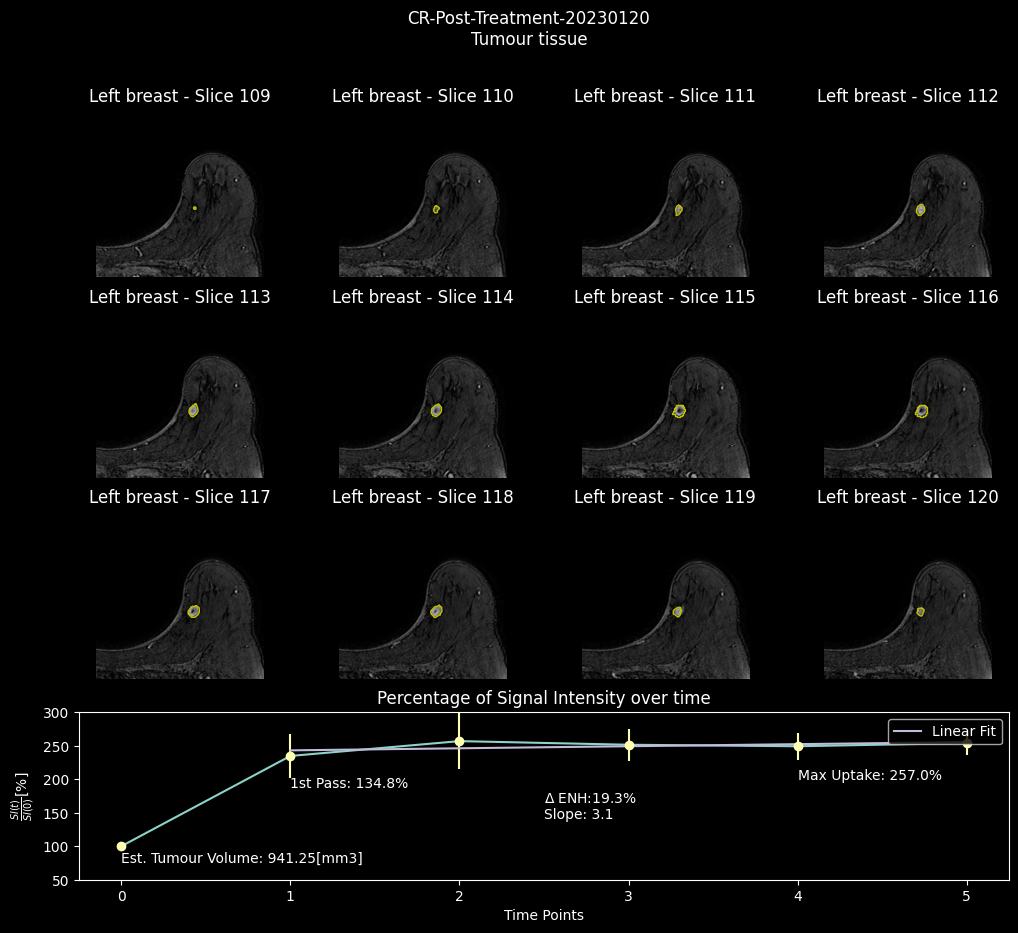

Skipping landmark blood vessel
Skipping landmark duct
Skipping landmark major muscle
Skipping landmark nipple
Skipping landmark clip in tumour
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PreTreatment:
	Estimated Volume: 1133.25[mm3]
	Maximum Enhancement: 247.80[%]
	1st Pass Enhancement: 146.34[%]
	Delta Enhancement: -4.66[%]
	Enhancement Slope: -1.15[]


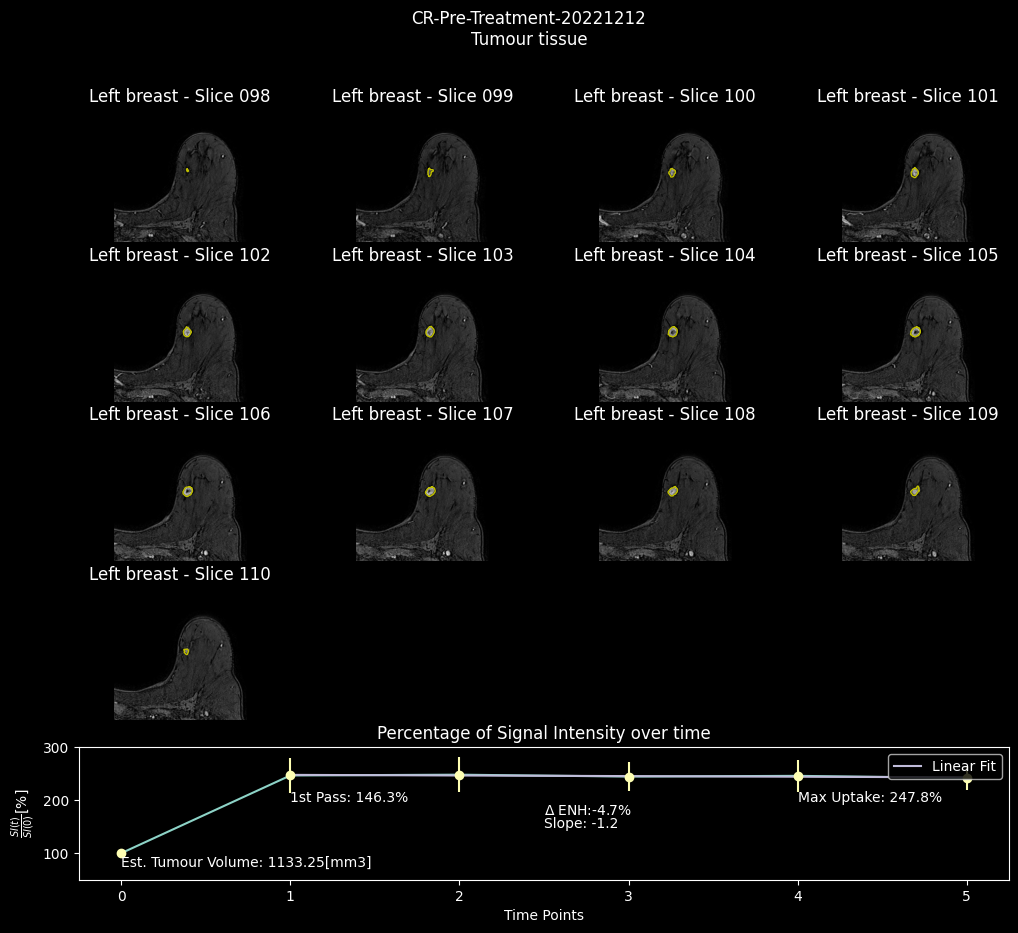

Skipping landmark blood vessel
Skipping landmark duct
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Skipping landmark nipple
Skipping landmark clip in tumour
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PostTreatment:
	Estimated Volume: 692.12[mm3]
	Maximum Enhancement: 183.24[%]
	1st Pass Enhancement: 58.73[%]
	Delta Enhancement: 24.51[%]
	Enhancement Slope: 5.57[]


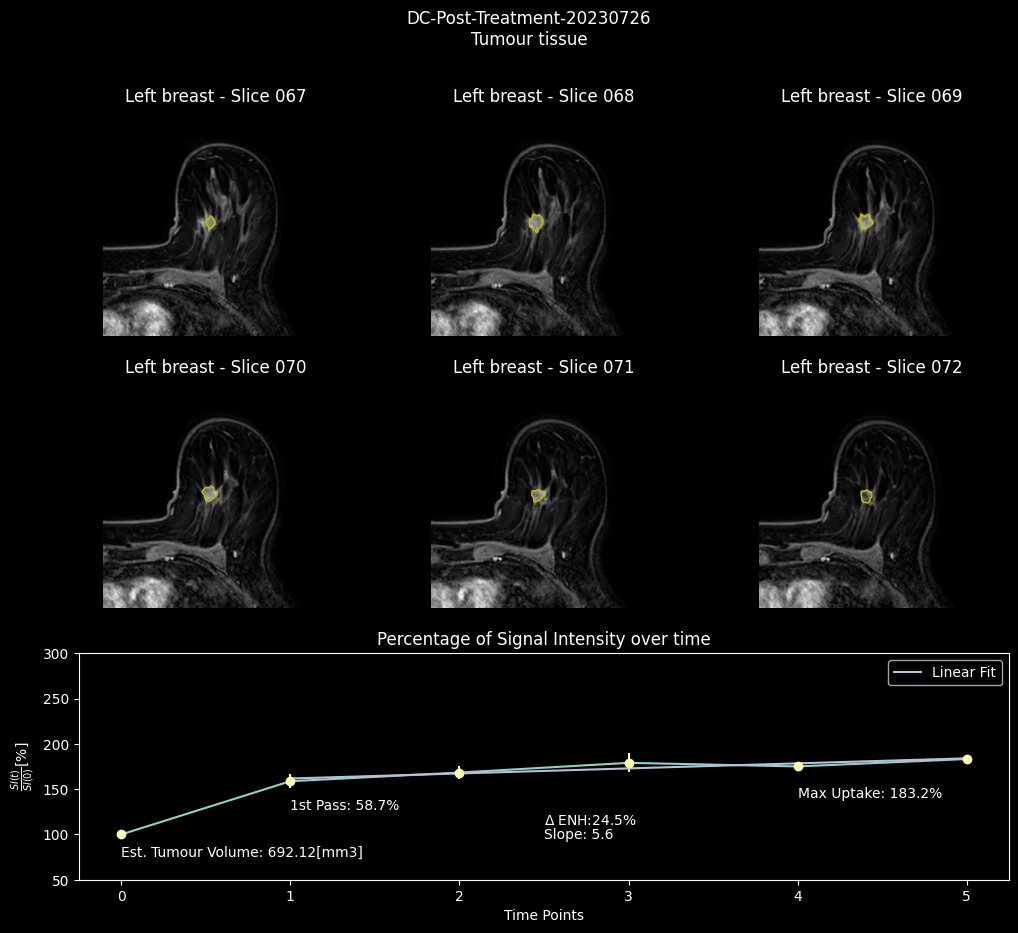

Skipping landmark blood vessel
Skipping landmark glandular tissue
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Skipping landmark ligament
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PreTreatment:
	Estimated Volume: 1122.35[mm3]
	Maximum Enhancement: 195.03[%]
	1st Pass Enhancement: 84.78[%]
	Delta Enhancement: 10.25[%]
	Enhancement Slope: 2.22[]


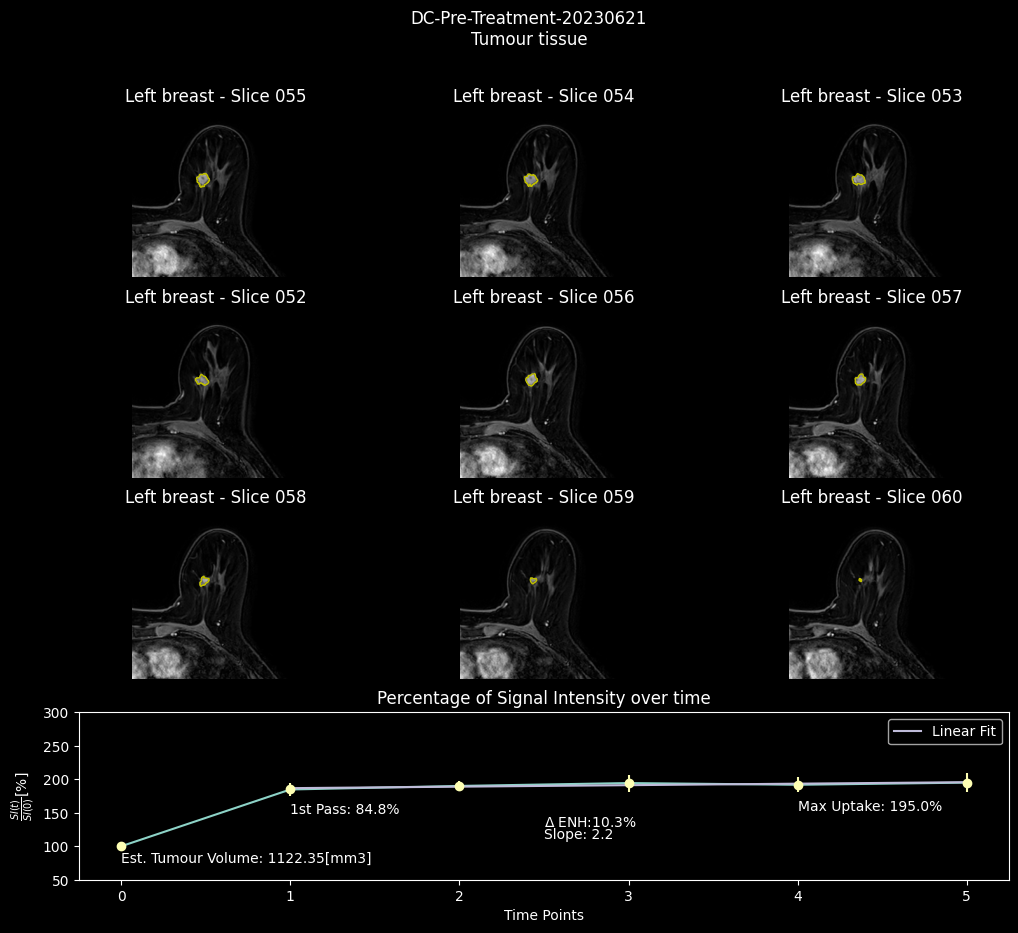

Skipping landmark blood vessel
Skipping landmark glandular tissue
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PostTreatment:
	Estimated Volume: 234.17[mm3]
	Maximum Enhancement: 176.10[%]
	1st Pass Enhancement: 53.15[%]
	Delta Enhancement: 22.37[%]
	Enhancement Slope: 5.38[]


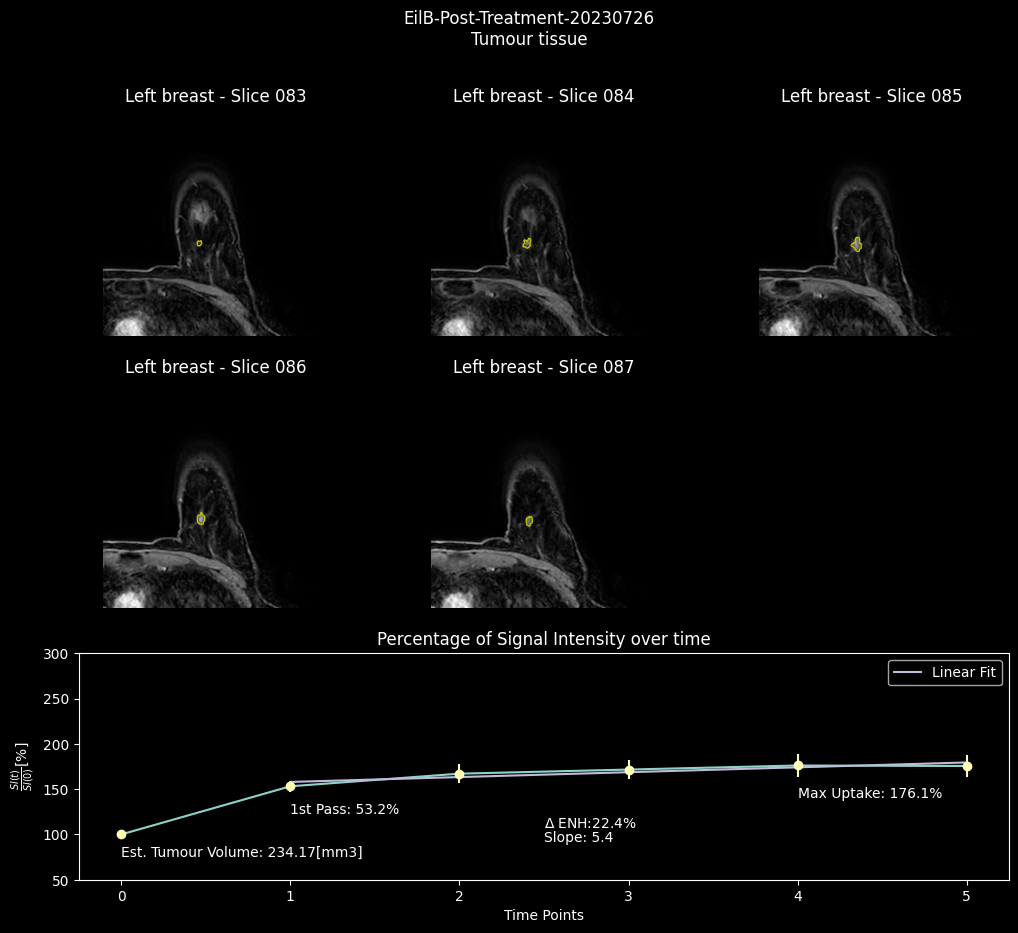

Skipping landmark glandular tissue
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PreTreatment:
	Estimated Volume: 481.50[mm3]
	Maximum Enhancement: 172.92[%]
	1st Pass Enhancement: 51.30[%]
	Delta Enhancement: 21.62[%]
	Enhancement Slope: 5.23[]


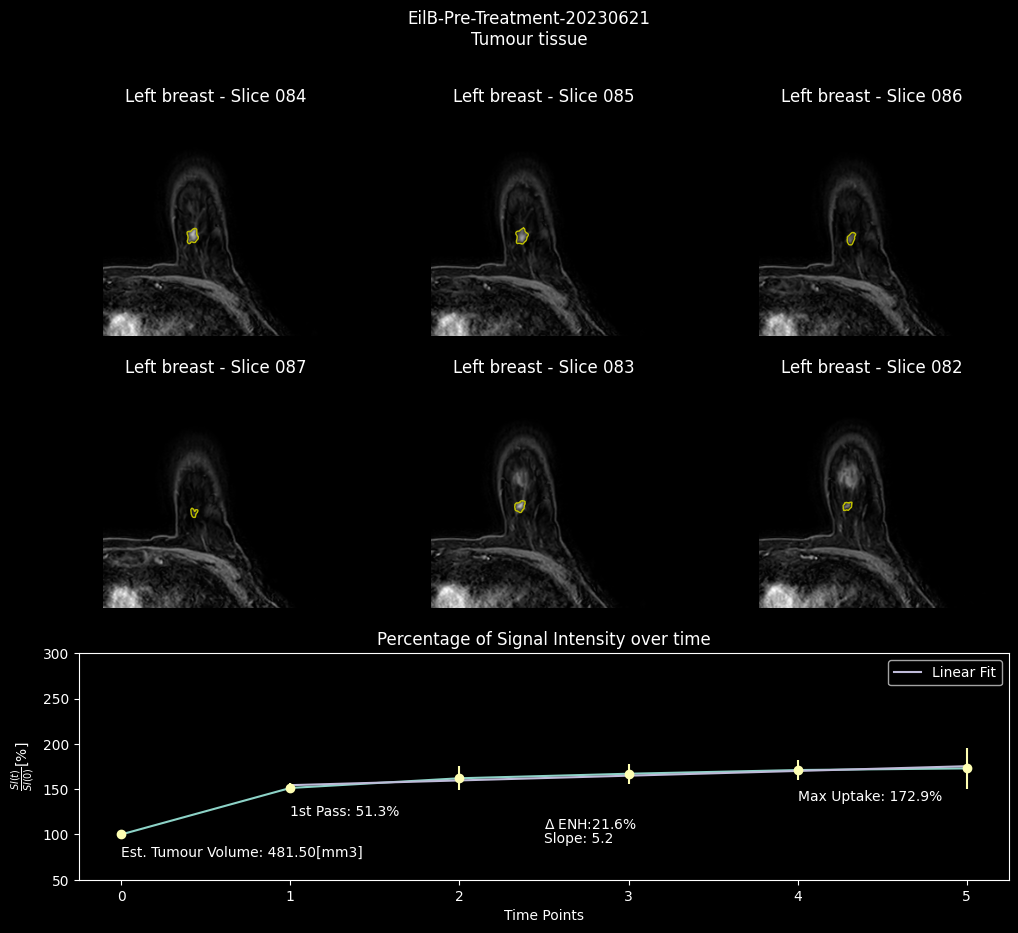

Skipping landmark glandular tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PostTreatment:
	Estimated Volume: 438.55[mm3]
	Maximum Enhancement: 103.90[%]
	1st Pass Enhancement: 3.90[%]
	Delta Enhancement: -2.14[%]
	Enhancement Slope: -0.31[]


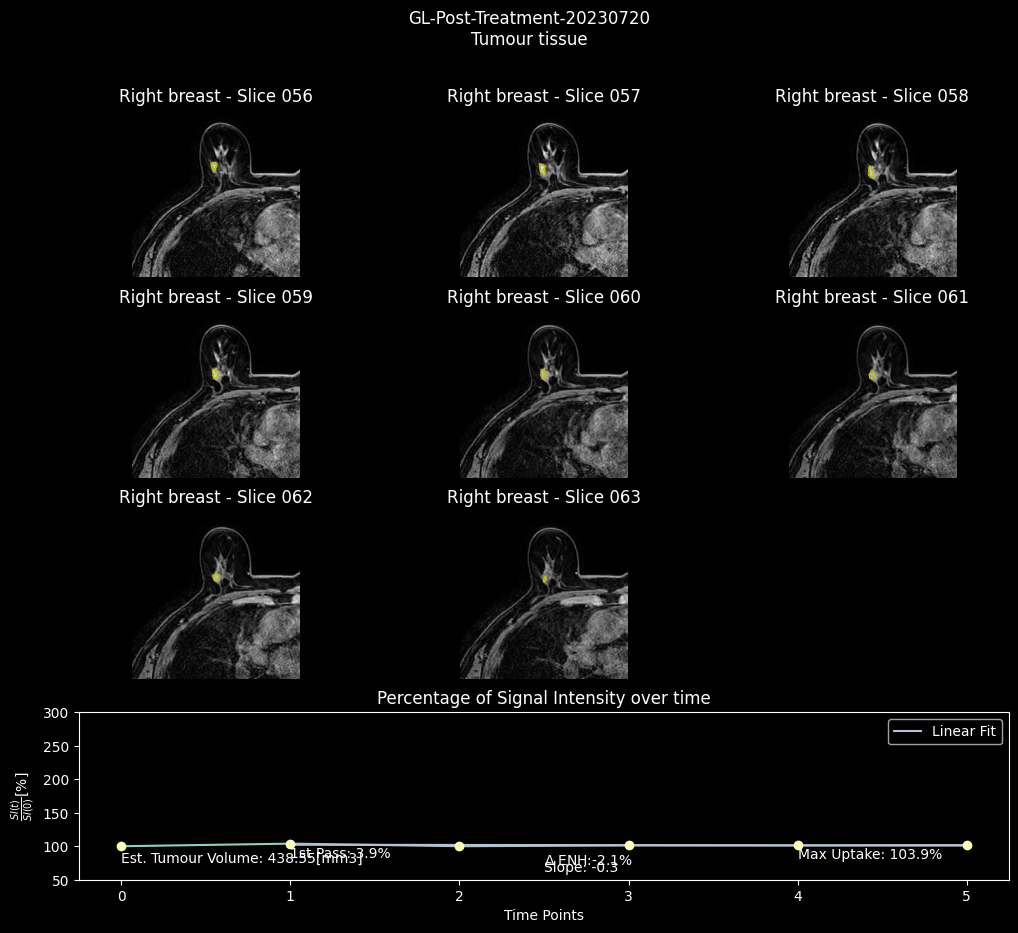

Skipping landmark glandular tissue
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PostTreatment:
	Estimated Volume: 178.74[mm3]
	Maximum Enhancement: 193.79[%]
	1st Pass Enhancement: 70.70[%]
	Delta Enhancement: 23.09[%]
	Enhancement Slope: 5.20[]


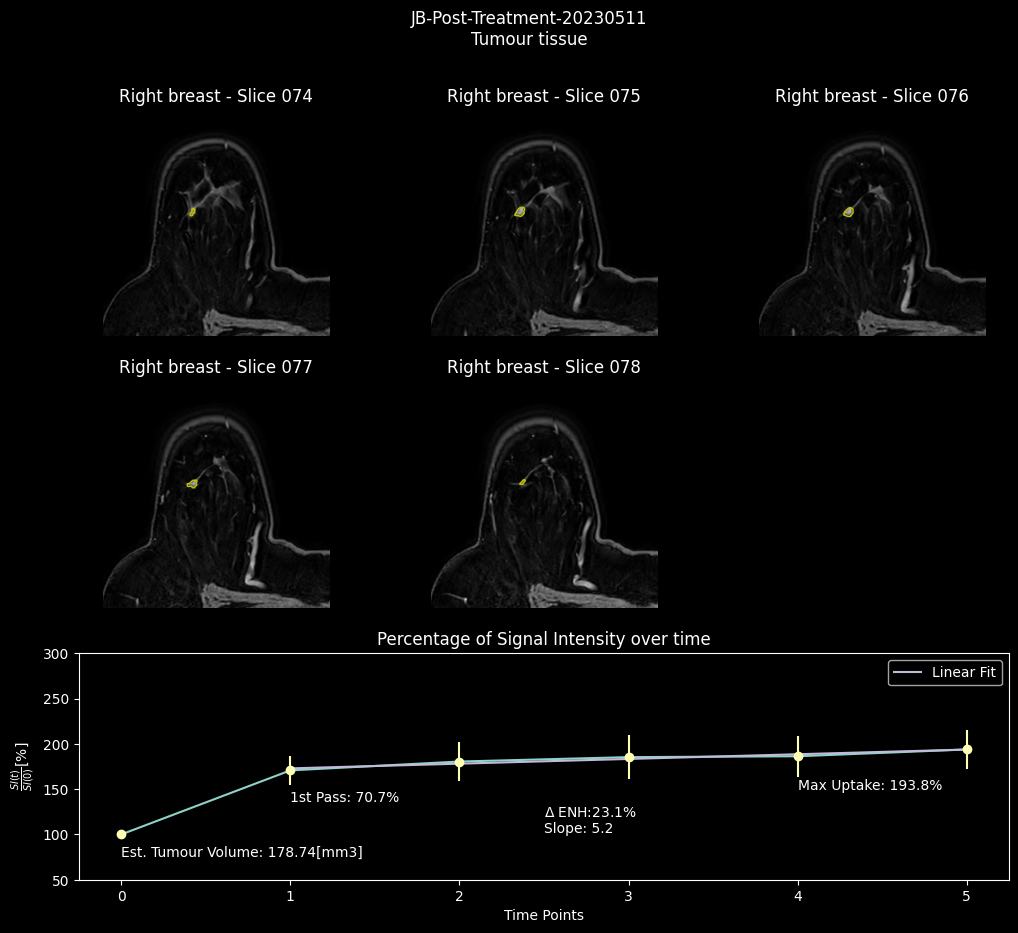

Skipping landmark blood vessel
Skipping landmark glandular tissue
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PreTreatment:
	Estimated Volume: 326.31[mm3]
	Maximum Enhancement: 180.64[%]
	1st Pass Enhancement: 77.86[%]
	Delta Enhancement: 2.34[%]
	Enhancement Slope: 0.15[]


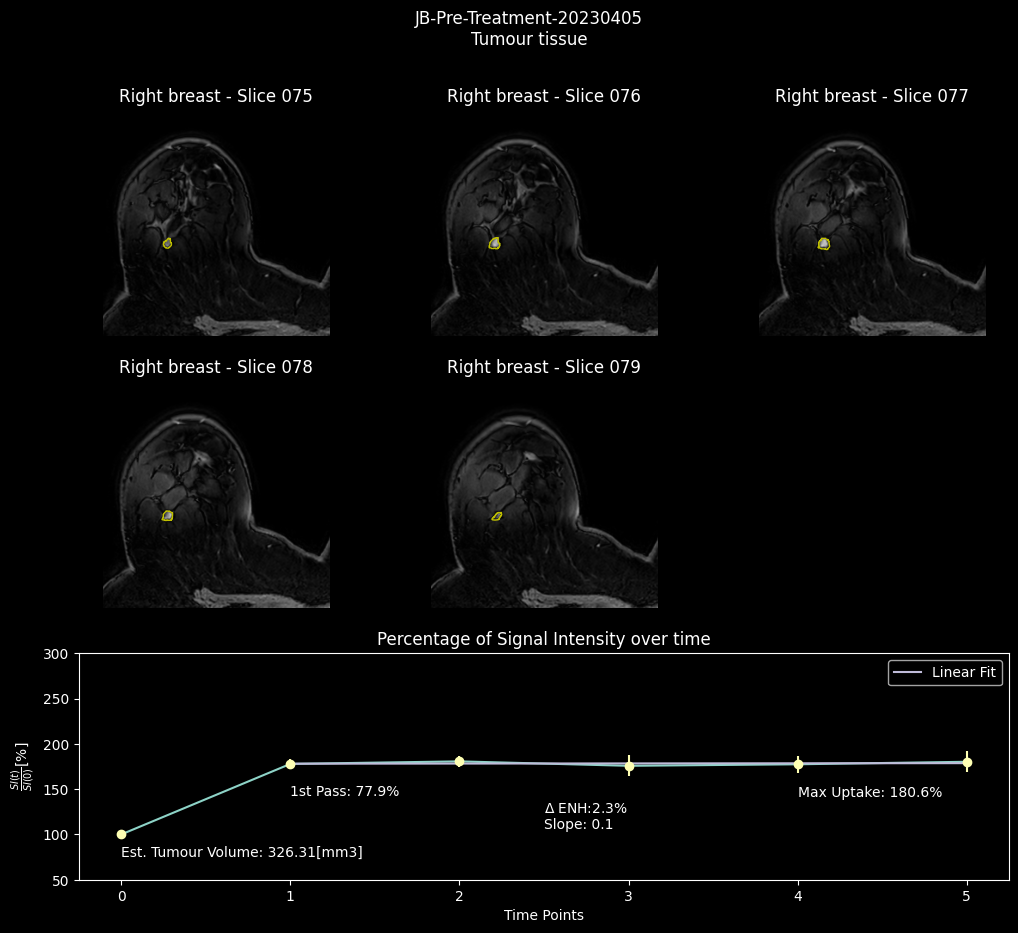

Skipping landmark blood vessel
Skipping landmark glandular tissue
Skipping landmark fat tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PostTreatment:
	Estimated Volume: 373.75[mm3]
	Maximum Enhancement: 239.36[%]
	1st Pass Enhancement: 85.65[%]
	Delta Enhancement: 53.71[%]
	Enhancement Slope: 13.46[]


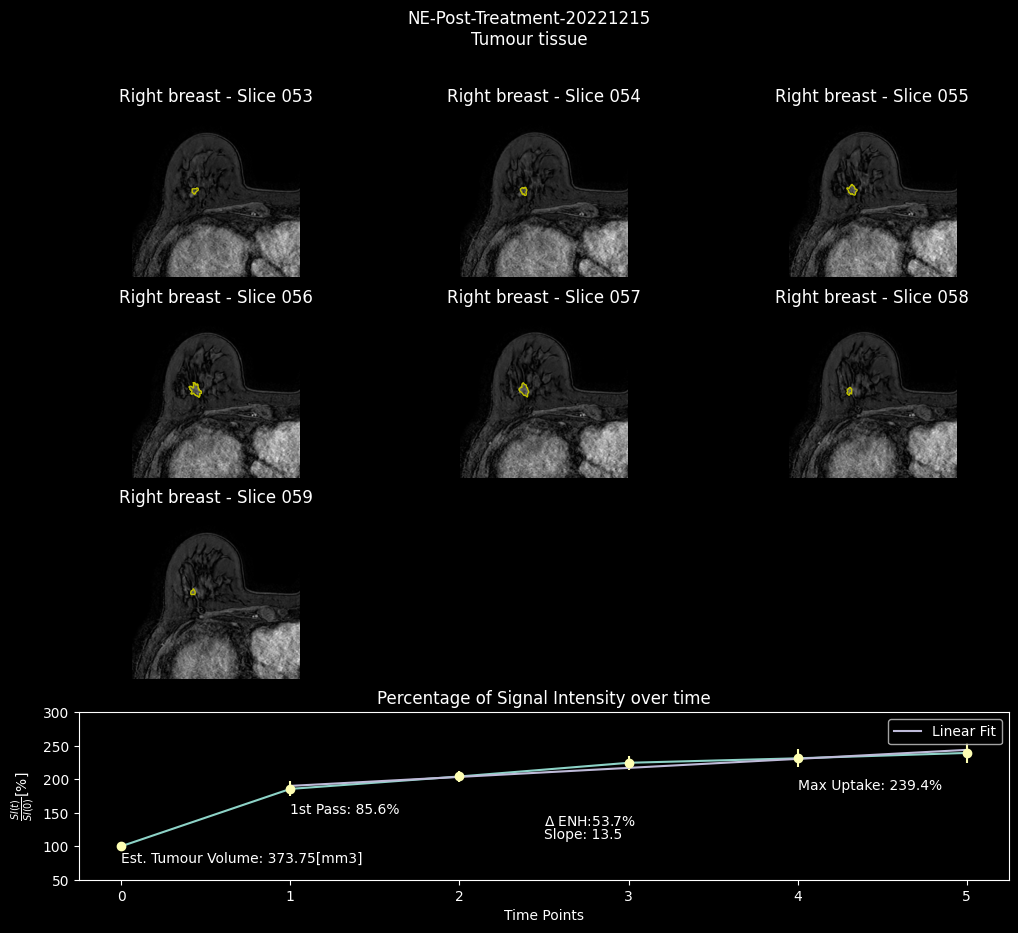

Skipping landmark duct
Skipping landmark glandular tissue
Skipping landmark pectoralis muscle
Processing time curves for landmark: tumour tissue
Summary statistics for tumour tissue ROIs in PreTreatment:
	Estimated Volume: 750.00[mm3]
	Maximum Enhancement: 246.19[%]
	1st Pass Enhancement: 116.94[%]
	Delta Enhancement: 29.25[%]
	Enhancement Slope: 7.54[]


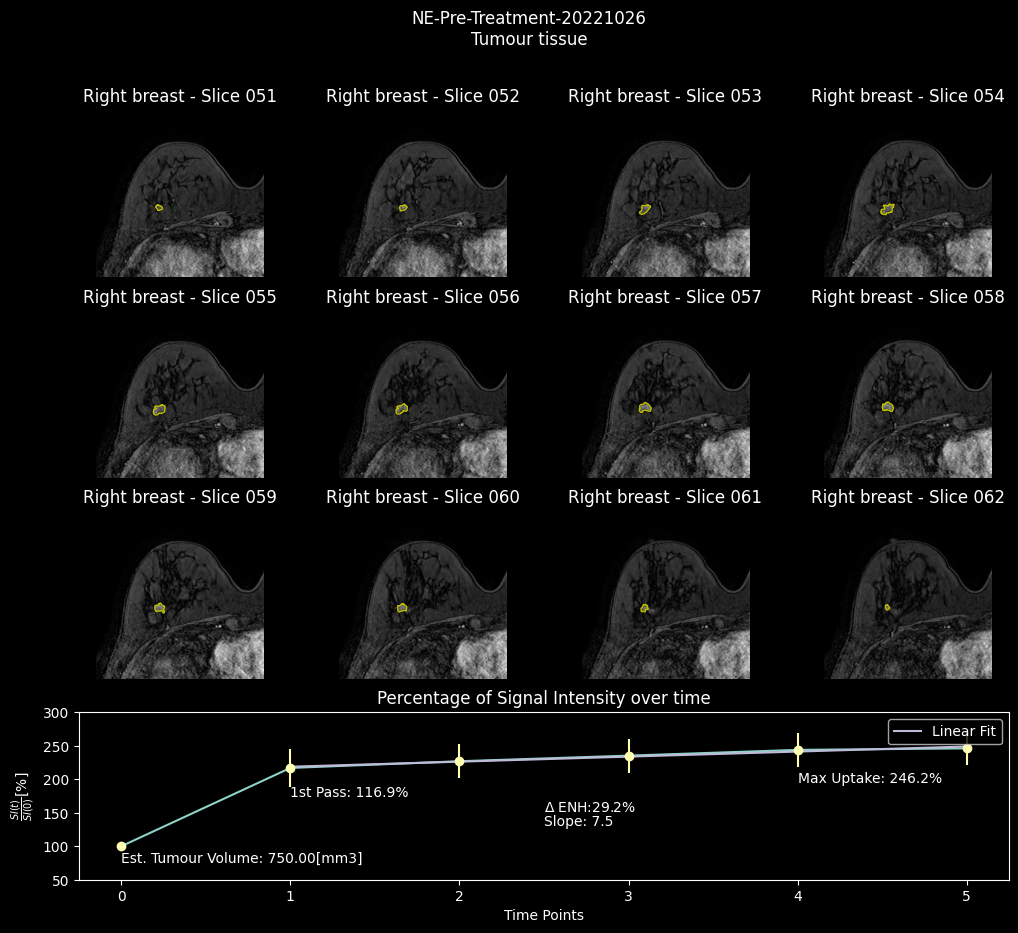

Skipping landmark blood vessel
Skipping landmark duct
Skipping landmark glandular tissue


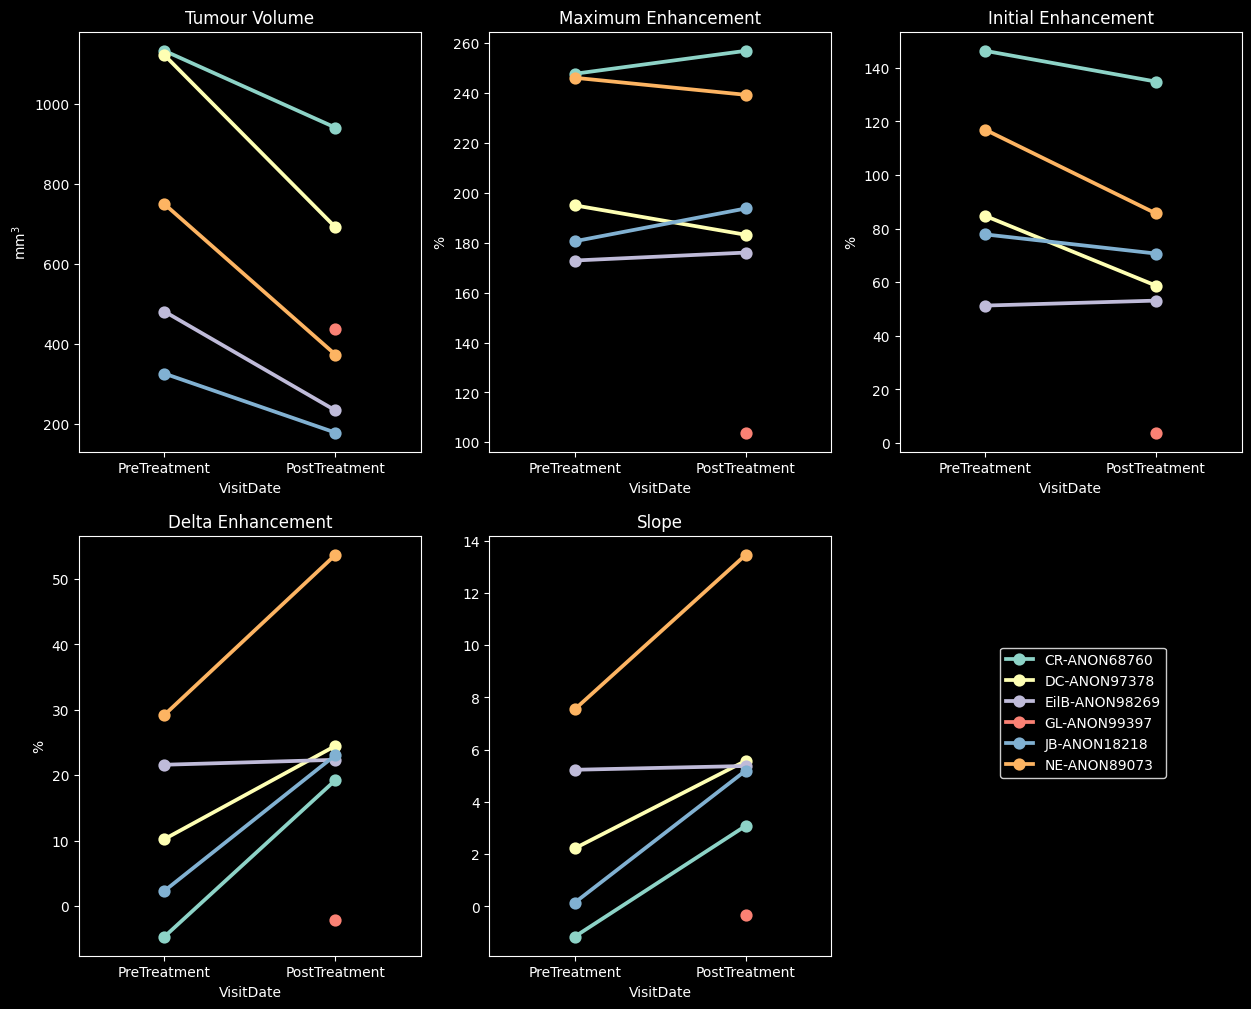

In [65]:
if run_qualit_analysis:
    stats_summary = {'Tumour Volume': r'$\text{mm}^{3}$',
                    'Maximum Enhancement': '%',
                    'Initial Enhancement': '%',
                    'Delta Enhancement': '%',
                    'Slope': ''
                    }
    stats_name = list(stats_summary.keys())

    hdr_name = ['PatientID', 'VisitDate', 'SequenceNro', 'Landmark'] + stats_name #, 'Tumour Volume (mm3)', 'Maximum Enhancement', 'Initial Enhancement', 'Delta Enhancement', 'Slope']
    stats_vals = []
    for idx_patient, patient in enumerate(dataset_to_process['datasets'].keys()):
        start_registering_patient = time.perf_counter()
        for idx_visit, patient_visit in enumerate(dataset_to_process['datasets'][patient]['visits']):
            for sequence in dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences']:
                # Pattern of the ROI filename: RoiSet-Frame<fixed_volume_position+1:03d>-<sequence>.zip
                path_to_roi = os.path.join(path_to_landmarks,
                                           patient,
                                           os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path']),
                                           'landmarks', 
                                           f'RoiSet-Frame{fixed_volume_pos+1:03d}-{sequence}.zip')
                # Load the image volume and see how can I overlay the ROI:
                path_to_volume = os.path.join(path_to_volumes, patient, 
                                              dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path'], 
                                              '.'.join([dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path'].replace(os.sep,'.'),
                                                        'nii.gz']))
                if os.path.isfile(path_to_roi):
                    # There exists a set of ROIs for the dataset (patient and visit)
                    # Then load the ROI file and 4D image file:
                    roi_zip_file = roifile.ImagejRoi.fromfile(path_to_roi)
                    volume_4d_file = itk.imread(path_to_volume)
                    # Number of timepoints in the image and image size:
                    [nt, nz, ny, nx] = volume_4d_file.shape
                    taxis = np.linspace(0, nt, nt, endpoint=False)
                    # Get Image resolution:
                    image_resolution = volume_4d_file.GetSpacing()
                    # TODO: Group the ROIs by landmark, so any landmark can have multiple ROIs in a single slice (i.e. use the index parameter) or single ROIs in multiple slices:
                    # Make use of ROI dictionary, but don't use dict.fromkeys as it creates just pointers to a same variable (see the link below)
                    # https://stackoverflow.com/questions/67953548/error-appending-list-elements-to-dictionary-in-python
                    # Using Matplotlib to display the images (for now skip the 3D visualisation issue with itk.view)
                    # There are nrois ROIs for the particular dataset, but they can be in the same slice
                    nrois = len(roi_zip_file)
                    si_landmarks = {k: [] for k in roi_dictionary['landmarks'].keys()}
                    for roi in roi_zip_file:
                        
                        [slice_nro, locID, landmrkID, landmarkIDX] = roi.name.split('-')
                        si_landmarks[landmrkID.lower()].append(roi)
                
                    # Keep only the non-empty lists:
                    si_landmarks = {k:v for k,v in si_landmarks.items() if v}
                
                    if landmark_sel == '':
                        # If there is no landmark selected, creates one figure per landmark:
                        nfigs = len(si_landmarks)
                    else:
                        # If a selected landmark, then just one figure is needed per dataset:
                        nfigs = 1
                
                    # Loop over the si_landmark dictionary to plot what is in there:
                    for landmark, landmark_rois in si_landmarks.items():
                                
                        # Count unique slices (via SET):
                        nslices = len(([slice_i.z_position for slice_i in landmark_rois]))
                        ncols = int(np.ceil(np.sqrt(nslices)))
                        nrows = int(np.ceil(nslices/ncols)) + 1

                        if landmark_sel == '':
                            # TODO: not yet implemented
                            print('Option to display time curves for all ROIs in a dataset has not yet been implemented.')
                        elif (landmark_sel == landmark):
                            # Stores signal intensity for every slice, if more than one index, try to average them:
                            # TODO: Average index
                            landmark_si = np.zeros((nslices, nt))
                            landmark_vol = np.zeros((nslices,))
                            
                            roi_label = f"{roi_dictionary['landmarks'][landmark]}"
                            if DEBUGMODE:
                                print(f"Processing time curves for landmark: {roi_label}")
                            fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(rows_width, cols_heigth), sharey='row')
                            fig.suptitle(f"{os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path'])}\n{roi_label.capitalize()}")
                            tcourse_ax = fig.add_subplot(nrows,1,nrows)
                            if len(ax) == 1:
                                axr = [ax]
                            else:
                                axr = ax.ravel()
                                for last_row_axes in ax[-1,:]:
                                    last_row_axes.remove()
                            # overlay the ROI in the corresponding slice:
                            for idx_slice, slice_i in enumerate(landmark_rois):
                                coordinates = (slice_i.t_position - 1, slice_i.z_position - 1) # Indices start in 0, but in ImageJ, slice and time points start in 1
                                [_, roi_loc, roi_landmark, _] = slice_i.name.split('-')
                                img_title = f"{roi_dictionary['locations'][roi_loc.lower()].capitalize()} - Slice {(coordinates[1]+1):03d}"
                                slice_to_plot = volume_4d_file[coordinates[0],coordinates[1],:,:]
                                axr[idx_slice].imshow(slice_to_plot, cmap='gray')
                                axr[idx_slice].set_title(img_title)
                                slice_i.plot(ax=axr[idx_slice], linewidth=1, color='y')
                                if slice_i.name.split('-')[1] == 'LB':
                                    axr[idx_slice].axis([int(0.45*nx), int(0.95*nx), 
                                                        int(0.60*ny), int(0.10*ny)])
                                elif slice_i.name.split('-')[1] == 'RB':
                                    axr[idx_slice].axis([int(0.05*nx), int(0.55*nx),
                                                        int(0.60*ny), int(0.10*ny)])
                                axr[idx_slice].axis('off')

                                # Create a mask from the set of coordinates:
                                mask = np.zeros_like(slice_to_plot, dtype=np.uint8)
                                pts = slice_i.coordinates().round().astype(np.int32)
                                mask = cv2.fillPoly(mask, [pts], (1))
                                mask = cv2.erode(mask, kernel, iterations=1)
                                
                                # To summarise the ROI is better to use the median than the mean (see e.g.  )
                                landmark_si[idx_slice, :] = [np.ma.median(np.ma.masked_where(mask==0, np.asarray(volume_4d_file[ti,coordinates[1],:,:] * mask))) for ti in range(volume_4d_file.shape[0])]
                                landmark_vol[idx_slice] = np.count_nonzero(mask)*np.prod(image_resolution)
                            idx_slice += 1
                            while (idx_slice < ((nrows-1)*ncols)):
                                axr[idx_slice].remove()
                                idx_slice += 1
                            landmark_pc_si = 100*landmark_si/landmark_si[:,0][:,None]

                            avg_si = np.mean(landmark_pc_si, axis=0)
                            std_si = np.std(landmark_pc_si, axis=0) 
                            
                            y_hat = avg_si[t0:]
                            first_pass_enh = avg_si[t0]-avg_si[0]
                            max_uptk = np.max(avg_si)
                            delta_enh = avg_si[-1] - avg_si[t0]
                            p = np.polyfit(taxis[t0:], y_hat, 1)
                            slope = p[0]
                            est_vol = np.sum(landmark_vol)
                            
                            print(f'Summary statistics for {roi_label} ROIs in {patient_visit}:')
                            print(f'\tEstimated Volume: {est_vol:.2f}[mm3]')
                            print(f'\tMaximum Enhancement: {max_uptk:.2f}[%]')
                            print(f'\t1st Pass Enhancement: {first_pass_enh:.2f}[%]')
                            print(f'\tDelta Enhancement: {delta_enh:.2f}[%]')
                            print(f'\tEnhancement Slope: {slope:.2f}[]')

                            tcourse_ax.plot(taxis, avg_si, '.-')
                            tcourse_ax.errorbar(taxis, 
                                                avg_si, 
                                                yerr=std_si, fmt='o')
                    
                            tcourse_ax.text(taxis[0], 75, f'Est. Tumour Volume: {est_vol:.2f}[mm3]')
                            tcourse_ax.text(taxis[-2], 0.80*avg_si[-2], f'Max Uptake: {max_uptk:0.1f}%')
                            tcourse_ax.text(0.5*taxis[-1], 0.70*avg_si[t0], r'$\Delta$ ENH:' + f'{delta_enh:0.1f}%')
                            tcourse_ax.text(0.5*taxis[-1], 0.60*avg_si[t0], f'Slope: {p[0]:0.1f}')
                            tcourse_ax.text(t0, 0.80*avg_si[t0], f'1st Pass: {first_pass_enh:0.1f}%')
                            tcourse_ax.plot(taxis[t0:], np.polyval(p, taxis[t0:]), label='Linear Fit')
                            tcourse_ax.set_ylim([50, 300])

                            tcourse_ax.set_title(f'Percentage of Signal Intensity over time')
                            tcourse_ax.set_xlabel(f'Time Points')
                            tcourse_ax.set_ylabel(r'$\frac{SI(t)}{SI(0)}$[%]')
                            tcourse_ax.legend(loc='upper right')

                            # 'Tumour Volume (mm3)', 'Maximum Enhancement', 'Initial Enhancement', 'Delta Enhancement', 'Slope'
                            stats_vals.append([patient, patient_visit, sequence, roi_label, est_vol, max_uptk, first_pass_enh, delta_enh, p[0]])
                            plt.savefig(os.path.join(subdir_paths['OUTPUTFLDR'], '.'.join([os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path']),
                                                                                           imge_label,
                                                                                           'png'])))
                            plt.show()
                        else:
                            print(f"Skipping landmark {roi_dictionary['landmarks'][landmark]}")

    df = pd.DataFrame(columns=hdr_name, data=stats_vals)
    ncplt = int(np.ceil(np.sqrt(len(stats_name))))
    nrplt = int(np.ceil(len(stats_name)/ncplt))
    
    fig, ax = plt.subplots(nrows=nrplt, ncols=ncplt, figsize=(15.0, 12.0))
    axr = ax.ravel()
    place_leg = True
    for idx_fig, par_name in enumerate(stats_name):
        place_legend = (idx_fig == (len(stats_name) - 1))
        sns.pointplot(data=df, x='VisitDate', y=par_name, hue='PatientID', ax=axr[idx_fig], order=sorted(df['VisitDate'].unique(), reverse=True), legend=place_legend)
        axr[idx_fig].set_title(par_name)
        axr[idx_fig].set_ylabel(stats_summary[par_name])
        if place_legend:
            axr[idx_fig].legend(loc='upper right', bbox_to_anchor=(2.0, 0.75),
                                fancybox=True, shadow=True, ncol=1)
    if idx_fig < (ncplt*nrplt - 1):
        axr[idx_fig+1].remove()         
    plt.savefig(os.path.join(subdir_paths['OUTPUTFLDR'], 
                            '.'.join([f'CE_parameters_{imge_label}','png'])))
    plt.show()
else:
    print(f'There are no ROI set defined for datasets in {STUDYNAME}. Qualitative analysis of time curves cannot be performed')


In [46]:
si_landmarks


{'tt': [ImagejRoi(
      roitype=ROI_TYPE.FREEHAND,
      options=ROI_OPTIONS.SUB_PIXEL_RESOLUTION,
      name='s010-RB-TT-001',
      version=228,
      top=275,
      left=167,
      bottom=287,
      right=177,
      n_coordinates=234,
      c_position=1,
      z_position=63,
      t_position=4,
      integer_coordinates=numpy.array([
          [ 3,  0],
          [ 2,  1],
          [ 2,  1],
          [ 2,  1],
          [ 2,  1],
          [ 2,  1],
          [ 2,  1],
          [ 2,  1],
          [ 2,  0],
          [ 1,  0],
          [ 1,  0],
          [ 1,  0],
          [ 1,  0],
          [ 1,  1],
          [ 1,  1],
          [ 1,  1],
          [ 1,  1],
          [ 1,  1],
          [ 1,  1],
          [ 0,  1],
          [ 0,  2],
          [ 0,  2],
          [ 0,  2],
          [ 0,  2],
          [ 0,  2],
          [ 0,  2],
          [ 0,  2],
          [ 0,  2],
          [ 0,  3],
          [ 0,  3],
          [ 0,  3],
          [ 0,  3],
          [ 0,  3],


In [ ]:
stats_summary = {'Tumour Volume': r'$\text{mm}^{3}$',
                 'Maximum Enhancement': '%',
                 'Initial Enhancement': '%',
                 'Delta Enhancement': '%',
                 'Slope': ''
                 }
stats_name = list(stats_summary.keys())

hdr_name = ['PatientID', 'VisitDate', 'SequenceNro', 'Landmark'] + stats_name #, 'Tumour Volume (mm3)', 'Maximum Enhancement', 'Initial Enhancement', 'Delta Enhancement', 'Slope']
stats_vals = []
for idx_patient, patient in enumerate(dataset_to_process['datasets'].keys()):
    start_registering_patient = time.perf_counter()
    for idx_visit, patient_visit in enumerate(dataset_to_process['datasets'][patient]['visits']):
        for sequence in dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences']:
            # Pattern of the ROI filename: RoiSet-Frame<fixed_volume_position+1:03d>-<sequence>.zip
            path_to_roi = os.path.join(path_to_landmarks, 
                                       patient, 
                                       os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path']), 
                                       'landmarks', 
                                       f'RoiSet-Frame{fixed_volume_pos+1:03d}-{sequence}.zip')
            # Load the image volume and see how can I overlay the ROI:
            path_to_volume = os.path.join(path_to_volumes, patient, 
                                          dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path'], 
                                          '.'.join([dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path'].replace(os.sep,'.'),
                                                    'nii.gz']))
            if os.path.isfile(path_to_roi):
                # There exists a set of ROIs for the dataset (patient and visit)
                # Then load the file and image:
                roi_zip_file = roifile.ImagejRoi.fromfile(path_to_roi)
                volume_4d_file = itk.imread(path_to_volume)
                # Using Matplotlib to display the images (for now skip the 3D visualisation issue with itk.view)
                # There are nrois ROIs for the particular dataset
                nrois = len(roi_zip_file)
                # Number of timepoints in the image and image size:
                [nt, nz, ny, nx] = volume_4d_file.shape
                taxis = np.linspace(0, nt, nt, endpoint=False)
                # Get Image resolution:
                image_resolution = volume_4d_file.GetSpacing()
                100*landmark_si/landmark_si[:,0][:,None]
                UptakeTimeCourse = 100*(volume_4d_file/(1e-6 + volume_4d_file[0,:,:,:]))
                UptakeTimeCourse[UptakeTimeCourse > 500] = 0
                MaxEnhMap = np.max(UptakeTimeCourse, axis=0)
                DeltaEnhMap = UptakeTimeCourse[-1, :, :, :] - UptakeTimeCourse[1, :, :, :]
                FirstPassMap = UptakeTimeCourse[1, :, :, :] - UptakeTimeCourse[0, :, :, :]
                LinFitMap = np.full((nz, ny, nx, 2), np.nan)
                print(f'Fitting on a pixel-by-pixel basis. Please wait...')
                time_fit_start = time.perf_counter()
                # for indz in range(nz):
                for indy in range(ny):
                    for indx in range(nx):
                        LinFitMap[:, indy, indx,:] = np.polyfit(taxis[t0:], np.array(UptakeTimeCourse[t0:, :, indy, indx]), 1).T
                print(f'End fitting slope')
                print(f'Elapsed time: {(time.perf_counter() - time_fit_start):0.2f}[s]')
                
                # TODO: Group the ROIs by landmark, so any landmark can have multiple ROIs in a single slice (i.e. index) or single ROIs in multiple slices:
                # Make use of ROI dictionary:
                # https://stackoverflow.com/questions/67953548/error-appending-list-elements-to-dictionary-in-python
                # si_landmark = dict.fromkeys(roi_dictionary['landmarks'].values(), [])
                si_landmarks = {k: [] for k in roi_dictionary['landmarks'].keys()}
                for roi in roi_zip_file:
                    [slice_nro, locID, landmrkID, landmarkIDX] = roi.name.split('-')
                    si_landmarks[landmrkID.lower()].append(roi)
            
                # Keep only the non-empty lists:
                si_landmarks = {k:v for k,v in si_landmarks.items() if v}
            
                if landmark_sel == '':
                    # If there is no landmark selected, creates one figure per landmark:
                    nfigs = len(si_landmarks)
                else:
                    # If a selected landmark, then just one figure is needed:
                    nfigs = 1
            
                # And loop over the si_landmark dictionary to plot what is in there:
                for landmark, landmark_rois in si_landmarks.items():                
                    # Count slices:
                    nslices = len(set([slice_i.z_position for slice_i in landmark_rois]))
                    ncols = int(np.ceil(np.sqrt(nslices)))
                    nrows = int(np.ceil(nslices/ncols)) + 1

                    if landmark_sel == '':
                        print('Plot everything...')
                    elif landmark_sel == landmark:
                        # Stores signal intensity for every slice, if more than one index, try to average them:
                        # TODO: Average index
                        landmark_si = np.zeros((nslices, nt))
                        landmark_vol = np.zeros((nslices,))
                        first_pass_enh = np.zeros((nslices,))
                        max_uptk = np.zeros((nslices,))
                        delta_enh = np.zeros((nslices,))
                        p = np.zeros((nslices,2))
                                          
                        roi_label = f"{roi_dictionary['landmarks'][landmark]}"
                        print(f"Landmark: {roi_label}")
                        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(rows_width, cols_heigth), sharey='row')
                        fig.suptitle(os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path']))
                        tcourse_ax = fig.add_subplot(nrows,1,nrows)
                        if len(ax) == 1:
                            axr = [ax]
                        else:
                            axr = ax.ravel()
                            for last_row_axes in ax[-1,:]:
                                last_row_axes.remove()
                        # overlay the ROI in the corresponding slice:
                        for idx_slice, slice_i in enumerate(landmark_rois):
                            coordinates = (slice_i.t_position - 1, slice_i.z_position - 1) # Indices start in 0, but in ImageJ, slice and time points start in 1
                            slice_to_plot = volume_4d_file[coordinates[0],coordinates[1],:,:]
                            axr[idx_slice].imshow(slice_to_plot, cmap='gray')
                            axr[idx_slice].set_title(slice_i.name)
                            slice_i.plot(ax=axr[idx_slice], linewidth=1, color='y')
                            if slice_i.name.split('-')[1] == 'LB':
                                axr[idx_slice].axis([int(0.45*nx), int(0.95*nx), 
                                                    int(0.60*ny), int(0.10*ny)])
                            elif slice_i.name.split('-')[1] == 'RB':
                                axr[idx_slice].axis([int(0.05*nx), int(0.55*nx),
                                                    int(0.60*ny), int(0.10*ny)])
                            axr[idx_slice].axis('off')

                            # Create a mask from the set of coordinates:
                            mask = np.zeros_like(slice_to_plot, dtype=np.uint8)
                            pts = slice_i.coordinates().round().astype(np.int32)
                            mask = cv2.fillPoly(mask, [pts], (1))
                            mask = cv2.erode(mask, kernel, iterations=1)
                            
                            # landmark_si[idx_slice, :] = [np.mean(np.asarray(volume_4d_file[ti,coordinates[1],:,:] * mask), where=(mask>0)) for ti in range(volume_4d_file.shape[0])]
                            landmark_si[idx_slice, :] = [np.ma.median(np.ma.masked_where(mask==0, np.asarray(UptakeTimeCourse[ti,coordinates[1],:,:] * mask))) for ti in range(nt)]
                            first_pass_enh[idx_slice] = np.ma.median(np.ma.masked_where(mask==0, np.asarray(FirstPassMap[coordinates[1],:,:] * mask)))
                            max_uptk[idx_slice] = np.ma.median(np.ma.masked_where(mask==0, np.asarray(MaxEnhMap[coordinates[1],:,:] * mask)))
                            delta_enh[idx_slice] = np.ma.median(np.ma.masked_where(mask==0, np.asarray(DeltaEnhMap[coordinates[1],:,:] * mask)))
                            p[idx_slice,:] = [np.ma.median(np.ma.masked_where(mask==0, np.asarray(LinFitMap[coordinates[1],:,:,indfit] * mask))) for indfit in range(2)]                         
                            landmark_vol[idx_slice] = np.count_nonzero(mask)*np.prod(image_resolution)
                        idx_slice += 1
                        while (idx_slice < ((nrows-1)*ncols)):
                            axr[idx_slice].remove()
                            idx_slice += 1
                        # landmark_pc_si = 100*landmark_si/landmark_si[:,0][:,None]

                        avg_si = np.mean(landmark_si, axis=0)
                        std_si = np.std(landmark_si, axis=0)
                        # avg_si = np.mean(landmark_pc_si, axis=0)
                        # std_si = np.std(landmark_pc_si, axis=0) 
                        
                        # y_hat = avg_si[t0:]
                        # first_pass_enh = avg_si[t0]-avg_si[0]
                        # max_uptk = np.max(avg_si)
                        # delta_enh = avg_si[-1] - avg_si[t0]
                        # p = np.polyfit(taxis[t0:], y_hat, 1)
                        avg_first_pass_enh = np.mean(first_pass_enh)
                        avg_max_uptk = np.mean(max_uptk)
                        avg_delta_enh = np.mean(delta_enh)
                        avg_p = np.mean(p, axis=0)
                        avg_slope = avg_p[0]
                        
                        print(f'{patient_visit}:')
                        est_vol = np.sum(landmark_vol)
                        print(f'\tVolume: {est_vol:.2f}[mm3]')
                        tcourse_ax.plot(taxis, avg_si, '.-')
                        tcourse_ax.errorbar(taxis, 
                                            avg_si, 
                                            yerr=std_si, fmt='o')
                
                        tcourse_ax.text(taxis[0], 75, f'Est. Tumour Volume: {est_vol:.2f}[mm3]')
                        tcourse_ax.text(taxis[-2], 0.80*avg_si[-2], f'Max Uptake: {avg_max_uptk:0.1f}%')
                        tcourse_ax.text(0.5*taxis[-1], 0.70*avg_si[t0], r'$\Delta$ ENH:' + f'{avg_delta_enh:0.1f}%')
                        tcourse_ax.text(0.5*taxis[-1], 0.60*avg_si[t0], f'Slope: {avg_slope:0.1f}')
                        tcourse_ax.text(t0, 0.80*avg_si[t0], f'1st Pass: {avg_first_pass_enh:0.1f}%')
                        tcourse_ax.plot(taxis[t0:], np.polyval(avg_p, taxis[t0:]), label='Linear Fit')
                        tcourse_ax.set_ylim([50, 300])

                        tcourse_ax.set_title(f'Percentage of Signal Intensity over time')
                        tcourse_ax.set_xlabel(f'Time Points')
                        tcourse_ax.set_ylabel(r'$\frac{SI(t)}{SI(0)}$[%]')
                        tcourse_ax.legend(loc='upper right')

                        # 'Tumour Volume (mm3)', 'Maximum Enhancement', 'Initial Enhancement', 'Delta Enhancement', 'Slope'
                        stats_vals.append([patient, patient_visit, sequence, roi_label, est_vol, 
                                           avg_max_uptk, avg_first_pass_enh, avg_delta_enh, avg_slope])

                        plt.savefig(os.path.join(subdir_paths['OUTPUTFLDR'], '.'.join([os.path.dirname(dataset_to_process['datasets'][patient]['visits'][patient_visit]['sequences'][sequence]['path']),
                                                                                       'map',
                                                                                       'png'])))
                        # plt.show()
                        
                    else:
                        print('skip')


df = pd.DataFrame(columns=hdr_name, data=stats_vals)
ncplt = int(np.ceil(np.sqrt(len(stats_name))))
nrplt = int(np.ceil(len(stats_name)/ncplt))

fig, ax = plt.subplots(nrows=nrplt, ncols=ncplt, figsize=(15.0, 12.0))
axr = ax.ravel()
place_leg = True
for idx_fig, par_name in enumerate(stats_name):
    place_legend = (idx_fig == (len(stats_name) - 1))
    sns.pointplot(data=df, x='VisitDate', y=par_name, hue='PatientID', ax=axr[idx_fig], order=sorted(df['VisitDate'].unique(), reverse=True), legend=place_legend)
    axr[idx_fig].set_title(par_name)
    axr[idx_fig].set_ylabel(stats_summary[par_name])
    if place_legend:
        axr[idx_fig].legend(loc='upper right', bbox_to_anchor=(2.0, 0.75),
                            fancybox=True, shadow=True, ncol=1)

if idx_fig < (ncplt*nrplt - 1):
    print(f'Index: {idx_fig} ({ncplt*nrplt})')
    axr[idx_fig+1].remove()
        
plt.savefig(os.path.join(subdir_paths['OUTPUTFLDR'], 
                         '.'.join(['CE_parameters_maps','png'])))
plt.show()
